In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/df_eddies_processed_1462_10650.pkl')

with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)
    
import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, smooth, tilt_distance_LI, compute_tilt_data, bearing


In [2]:
sample_eddies = [474, 971, 1917, 1978, 33, 207, 1783, 2370]
dic_sample = {}
for eddy in sample_eddies:
    eddy = f'Eddy{eddy}'
    dic_sample[eddy] = dic_eddies_vert[eddy]
# Unique colors for each eddy
colors = [c for i, c in enumerate(plt.get_cmap("tab10").colors) if i != 7]


In [3]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [4]:
n = len(z_r)
base = pd.DataFrame({'Depth': -z_r})
frames = []

for eddy, dic in dic_sample.items():
    for d, df in enumerate(dic.values()):
        if len(df):
            df2 = df.copy()
            cols = df2.columns.drop("Depth")
            df2[cols] = df2[cols].sub(df2[cols].iloc[0])
    
            tmp = (df2[['x','y']] if not df2.empty else pd.DataFrame(index=[], columns=['x','y']))
            tmp = tmp.reindex(range(n))                     # pads with NaNs
            tmp.columns = [f'{eddy}_x_{d}', f'{eddy}_y_{d}']
            frames.append(tmp)

df_depths = pd.concat([base, *frames], axis=1, copy=False)
df_depths


Depth Eddy474_x_0 Eddy474_y_0 Eddy474_x_1 Eddy474_y_1 Eddy474_x_2  \
0      1.783320         0.0         0.0         0.0         0.0         0.0   
1      5.879627   -0.974669    3.267336   -3.511558    5.025034   -2.413063   
2     10.725783   -1.468304    5.190251   -5.876605    7.776786    -2.83807   
3     16.383097   -2.327556    7.071354    -7.11271    8.968693   -3.034601   
4     22.925581   -2.989554    8.468213   -7.440385    9.246306    -3.28922   
5     30.444118     -4.0238   10.177934   -7.608215    9.363943   -3.934394   
6     39.052712   -5.802994   12.377652   -8.075858    9.844126   -3.345895   
7     48.897638   -8.180369   14.614348   -9.386631    10.28977   -2.332756   
8     60.170639    -8.70146   14.831316   -4.991233    3.828104   -3.667857   
9     73.127842  -11.447962   19.245664   -4.944514    4.928702   -3.042253   
10    88.116838   -13.17445   20.505933   -5.832761     6.47947   -2.579274   
11   105.615538  -11.623622   19.021474   -8.001417    9.871415   -2.009377   
12   126.288127  -10.607044   17.694439   -7.503959    9.650058    -1.61695   
13   151.065954   -6.632793   13.624144   -4.050031     7.28474   -0.715596   
14   181.264793   -4.084649    9.260565   -1.280475    4.865948    0.287492   
15   218.754856    -0.95778    4.503419    0.264508    2.287515    1.153119   
16   266.206398   -1.442214    3.792536    1.472761    0.620388    2.874572   
17   327.440851   -1.985894    4.084568    2.161265   -0.292418    4.473625   
18   407.922192   -1.955232    5.440425    2.257567   -0.350179    4.730502   
19   515.416489    -1.29493    7.992326      2.0134     2.34671    5.365596   
20   660.806374    0.581497   10.762508    5.722075    1.191316    6.625147   
21   858.918478    7.438354       1.935   10.407363   -6.405175    9.415358   
22  1128.898331   12.489213   -8.457375   16.825586  -19.774259   12.488527   
23  1492.971178         NaN         NaN   21.109849  -37.648345   15.409049   
24  1971.212518         NaN         NaN   19.753538    -57.5939   11.757965   
25  2568.677466         NaN         NaN  -10.999724  -37.390985    4.094581   
26  3252.716389         NaN         NaN         NaN         NaN     5.15434   
27  3930.053268         NaN         NaN         NaN         NaN         NaN   
28  4460.447022         NaN         NaN         NaN         NaN         NaN   
29  4748.917670         NaN         NaN         NaN         NaN         NaN   

   Eddy474_y_2 Eddy474_x_3 Eddy474_y_3 Eddy474_x_4  ... Eddy2370_x_52  \
0          0.0         0.0         0.0         0.0  ...           0.0   
1    -0.374425    0.162814   -2.763935    0.369236  ...     -5.474863   
2    -1.345578    0.879621   -5.991215    0.948314  ...     -6.802928   
3    -1.771417    1.807674   -9.299192    1.416047  ...     -9.284528   
4    -2.046559    4.218768  -13.449757    3.646617  ...     -9.173816   
5    -2.132741      6.8782  -17.108248    3.934756  ...     -9.314653   
6    -3.480717    8.561541  -19.062899    2.266827  ...     -9.413788   
7    -5.284549    8.980848  -19.008603    2.473281  ...     -9.465317   
8     -5.13038    7.377093  -16.801694    3.847553  ...     -9.549117   
9    -6.312951     6.52881  -17.152491    2.984857  ...     -9.655466   
10   -6.539645    6.444367  -18.169322    2.068348  ...     -9.747127   
11   -6.457633    6.511036  -18.790668    1.388335  ...     -9.765817   
12   -5.146431    5.925281  -17.722373    0.865539  ...     -9.508848   
13   -4.280821    5.830231  -15.422649   -0.751076  ...     -8.667713   
14   -4.061152    6.342942  -13.691658   -2.119002  ...     -8.395517   
15   -4.768603    5.997896  -11.284553   -2.544488  ...     -8.560935   
16   -6.187805    6.693088  -11.181174   -3.018195  ...     -8.458504   
17   -7.692321    8.029336  -12.152553   -1.841755  ...     -8.604947   
18   -8.402176    9.613072  -14.002014    0.789057  ...     -8.148812   
19   -7.536672   10.782431  -15.002118    2.007343  ...     -7.869544   
20    -6.74517   12.284183 

In [5]:
n = len(z_r)
base = pd.DataFrame({'Depth': -z_r})
frames = []

for eddy, dic in dic_sample.items():
    for d, df in enumerate(dic.values()):
        tmp = (df[['TD']] if not df.empty else pd.DataFrame(index=[], columns=['TD']))
        tmp = tmp.reindex(range(n))                     # pads with NaNs
        tmp.columns = [f'{eddy}_{d}']
        frames.append(tmp)
df_depths_TD = pd.concat([base, *frames], axis=1, copy=False)
df_depths_TD


Depth  Eddy474_0  Eddy474_1  Eddy474_2  Eddy474_3  Eddy474_4  \
0      1.783320   0.000000   0.000000   0.000000   0.000000   0.000000   
1      5.879627   3.409613   6.130416   2.441939   2.768726   2.784147   
2     10.725783   5.393943   9.747455   3.140895   6.055443   3.699353   
3     16.383097   7.444566  11.446750   3.513790   9.473260   4.298363   
4     22.925581   8.980426  11.868172   3.873935  14.095885   7.248095   
5     30.444118  10.944465  12.065171   4.475270  18.439137   7.320519   
6     39.052712  13.670443  12.732883   4.828085  20.897227   4.454589   
7     48.897638  16.748063  13.927965   5.776522  21.023382   5.230403   
8     60.170639  17.195446   6.290214   6.306661  18.349888   6.896773   
9     73.127842  22.393111   6.981427   7.007757  18.353019   5.272011   
10    88.116838  24.373334   8.718063   7.029908  19.278333   4.905265   
11   105.615538  22.291816  12.706986   6.763034  19.886749   4.693102   
12   126.288127  20.630137  12.224280   5.394468  18.686665   3.658179   
13   151.065954  15.152928   8.334878   4.340220  16.487865   1.161521   
14   181.264793  10.121384   5.031607   4.071316  15.089547   2.767330   
15   218.754856   4.604142   2.302757   4.906043  12.779511   4.158374   
16   266.206398   4.057500   1.598094   6.822909  13.031350   6.002847   
17   327.440851   4.541748   2.180957   8.898602  14.565534   5.358446   
18   407.922192   5.781103   2.284564   9.642314  16.984332   2.739323   
19   515.416489   8.096550   3.092059   9.251543  18.474966   2.386879   
20   660.806374  10.778205   5.844773   9.454622  19.873553   2.490739   
21   858.918478   7.685918  12.220453  15.958272  23.146174   2.523903   
22  1128.898331  15.083356  25.963853  25.903993  33.727907  11.602520   
23  1492.971178        NaN  43.162757  41.987905  43.011107  24.840357   
24  1971.212518        NaN  60.887269  40.636583  29.840567  32.235233   
25  2568.677466        NaN  38.975373  43.322441  11.628062        NaN   
26  3252.716389        NaN        NaN  26.713355        NaN        NaN   
27  3930.053268        NaN        NaN        NaN        NaN        NaN   
28  4460.447022        NaN        NaN        NaN        NaN        NaN   
29  4748.917670        NaN        NaN        NaN        NaN        NaN   

    Eddy474_5  Eddy474_6  Eddy474_7  Eddy474_8  ...  Eddy2370_47  Eddy2370_48  \
0    0.000000   0.000000   0.000000   0.000000  ...     0.000000     0.000000   
1    5.036956   3.214277   2.424924   2.713935  ...     1.705146     2.773097   
2    6.455060   8.964091   3.772259   3.822583  ...     2.579791     4.346501   
3    6.864451  13.675476   6.038910   4.986148  ...     3.244232     5.681487   
4    7.356477  16.573497   8.171251   7.176891  ...     3.807857     6.755305   
5    8.418693  15.837572   8.670386   6.332623  ...     4.297784     7.663287   
6   10.204511  15.800145   8.003932   5.870882  ...     4.394558     7.448691   
7    9.090433  16.545398   7.018271   5.088891  ...     4.379046     7.087094   
8   10.014883  15.594109   5.831705   4.705185  ...     4.399852     6.998592   
9   11.022681  16.766616   4.900340   3.046906  ...     4.418925     6.877978   
10   9.338120  17.630282   4.864767   3.614173  ...     4.390040     6.855085   
11   8.705269  17.224376   4.504683   6.022752  ...     4.443143     6.951350   
12   7.510704  13.891686   4.173234   6.038911  ...     4.420177     7.451124   
13   3.692045  10.732888   3.904901   4.875035  ...     4.139266     7.118450   
14   4.347384   7.505814   4.864370   5.624319  ...     4.697358     7.064973   
15   6.165534   4.449701   8.260164   6.752435  ...     4.970712     7.361394   
16   8.087912   4.273123   9.969327   8.150359  ...     4.542351     6.983758   
17   7.785456   4.358859   9.761793   9.234517  ...     4.603330     6.950252   
18   4.071871   4.957167   7.633996   7.086607  ...     4.917819     7.547706   
19   0.541447   6.777275   6.632249   7.911423  ...     5.195689     8.414673   
20   0.721018 

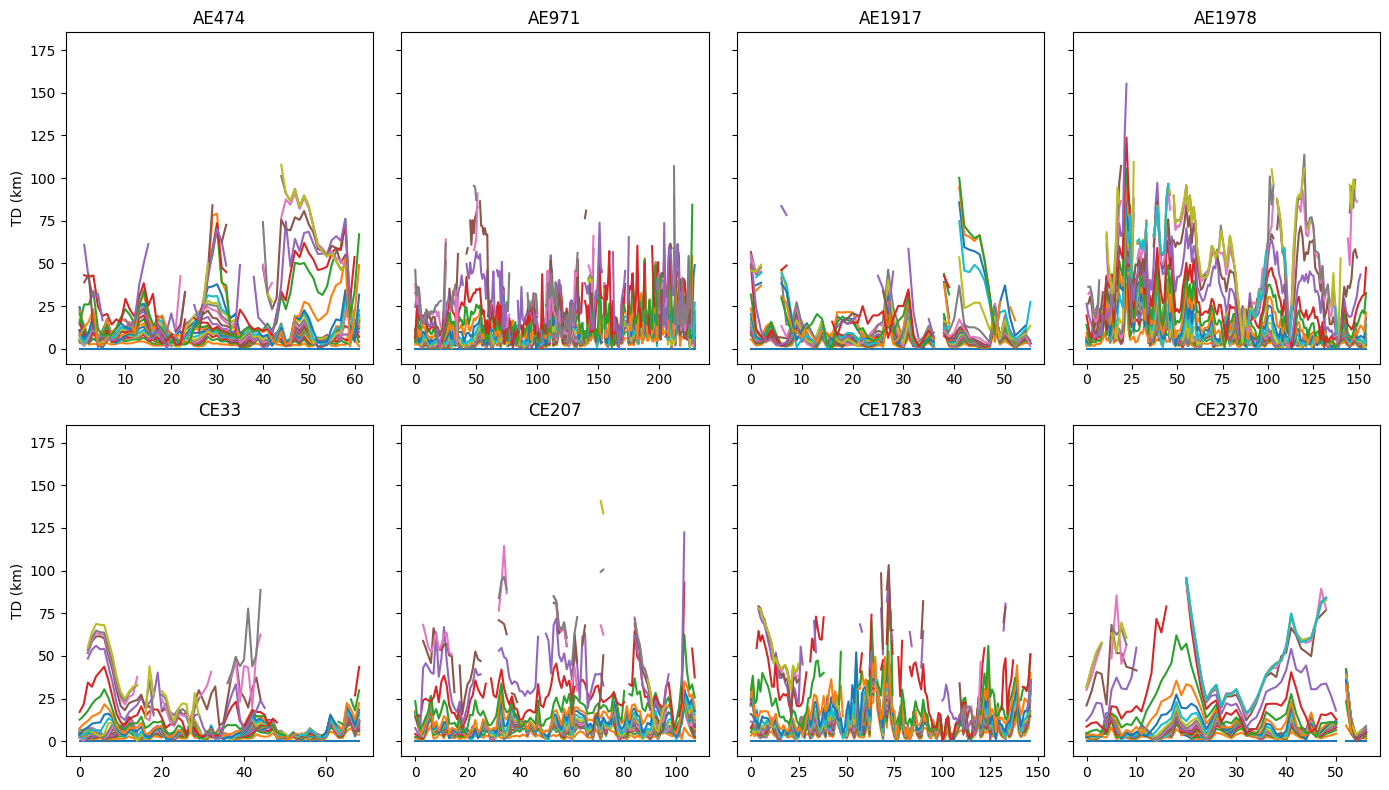

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(14,8), sharey=True)
# lvls = [11, 22, 24]
lvls = np.arange(len(z_r))
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    # df_sub = df.loc[:, df.columns.str.contains(f"Eddy{eddy}") | (df.columns == "Depth")]
    df_sub = df_depths_TD.loc[:, df_depths_TD.columns.str.contains(f'Eddy{eddy}')]
    for lvl in lvls:
        ax.plot(df_sub.iloc[lvl].values, label=round(-z_r[lvl]))
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
axs[0,0].set_ylabel('TD (km)')
axs[1,0].set_ylabel('TD (km)')
# axs[0,1].legend(ncol=2)
plt.tight_layout()


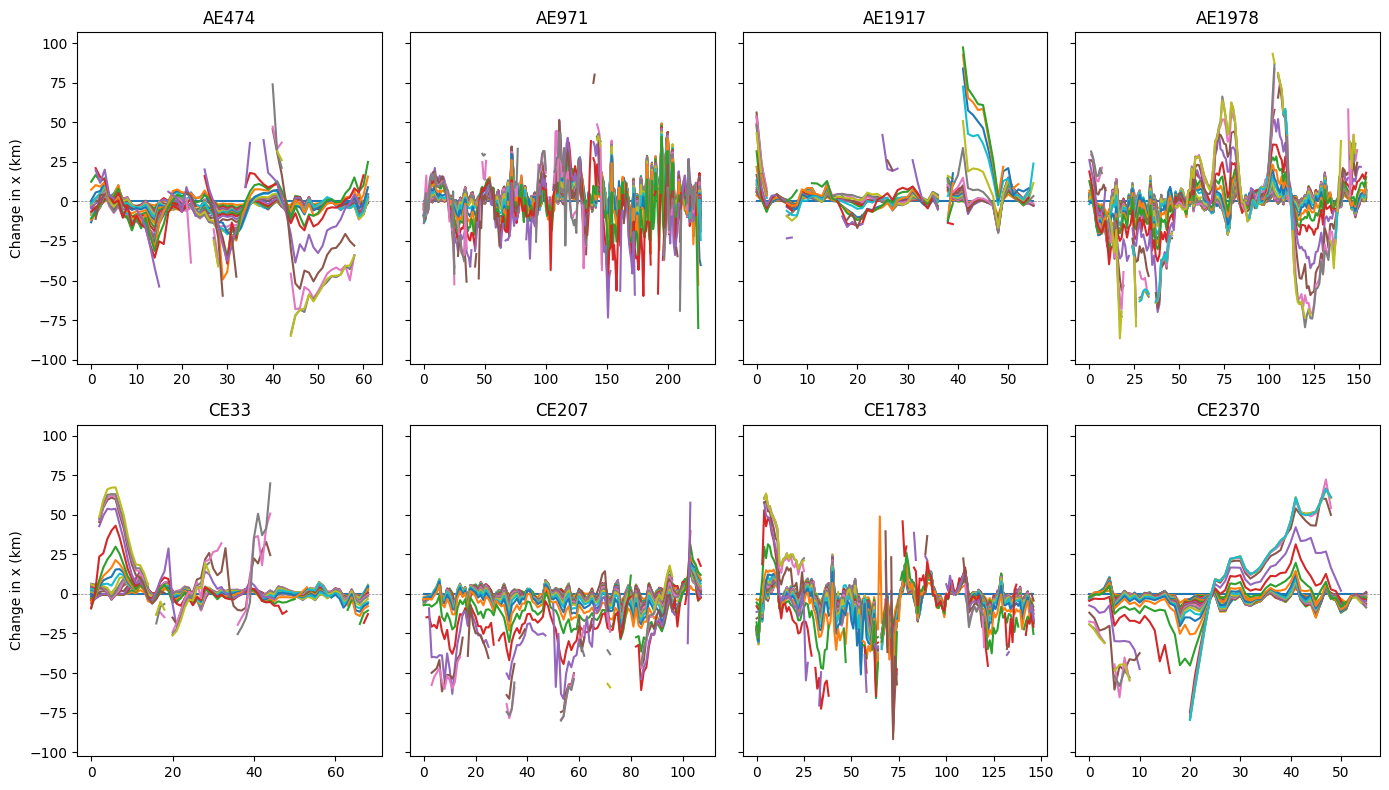

In [7]:
fig, axs = plt.subplots(2, 4, figsize=(14,8), sharey=True)
# lvls = [11, 22, 24]
lvls = np.arange(len(z_r))
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    ax.axhline(y=0, lw=.5, ls='--', color='k', alpha=.5)
    df_sub = df_depths.loc[:, df_depths.columns.str.contains(f'Eddy{eddy}_x')]
    for lvl in lvls:
        ax.plot(df_sub.iloc[lvl].values, label=round(-z_r[lvl]))
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
axs[0,0].set_ylabel('Change in x (km)')
axs[1,0].set_ylabel('Change in x (km)')
# axs[0,1].legend(ncol=2)
plt.tight_layout()

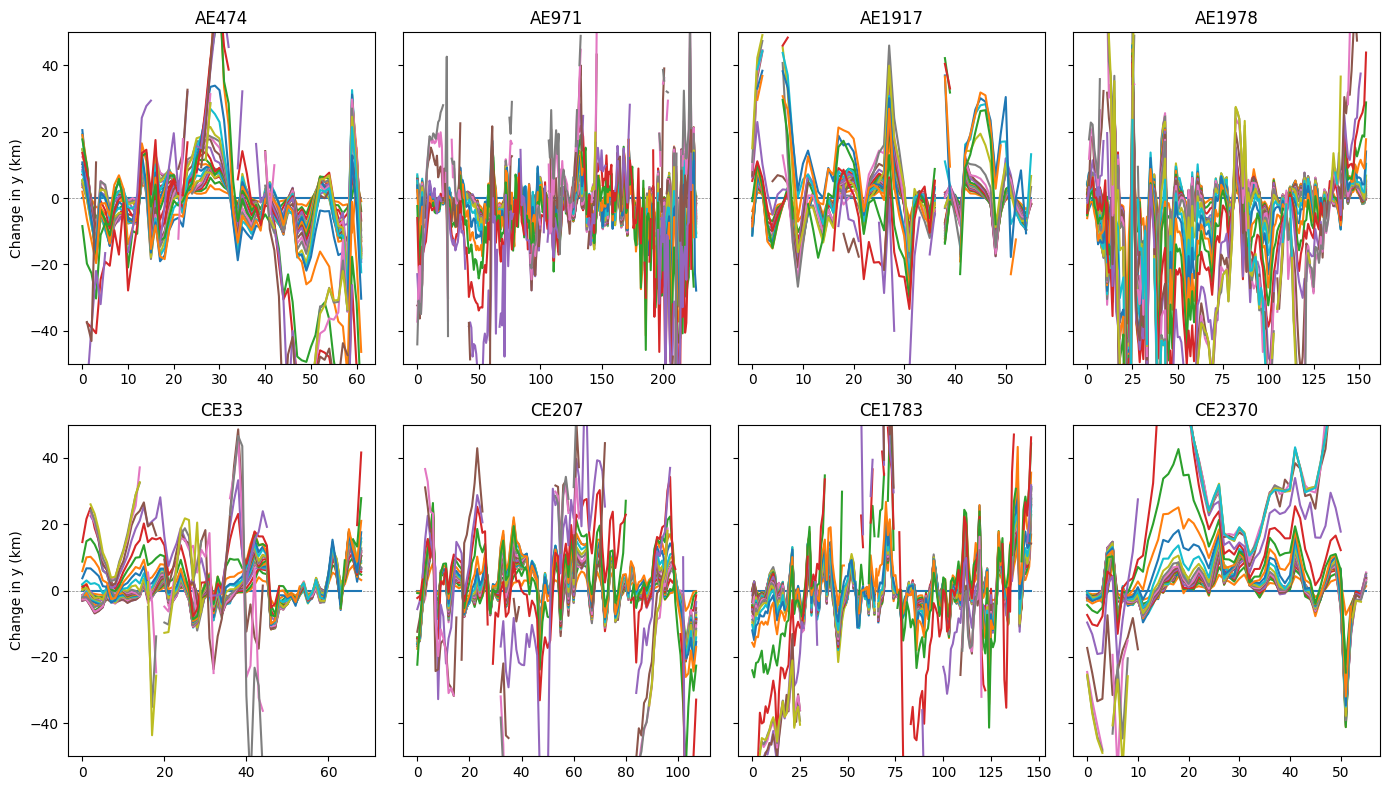

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(14,8), sharey=True)
lvls = [11, 22, 24]
lvls = np.arange(len(z_r))
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    ax.axhline(y=0, lw=.5, ls='--', color='k', alpha=.5)
    df_sub = df_depths.loc[:, df_depths.columns.str.contains(f'Eddy{eddy}_y')]
    for lvl in lvls:
        ax.plot(df_sub.iloc[lvl].values, label=round(-z_r[lvl]))
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    
axs[0,0].set_ylabel('Change in y (km)')
axs[1,0].set_ylabel('Change in y (km)')
axs[0,0].set_ylim(-50, 50)
# axs[0,1].legend(ncol=2)
plt.tight_layout()


### Li Tilt

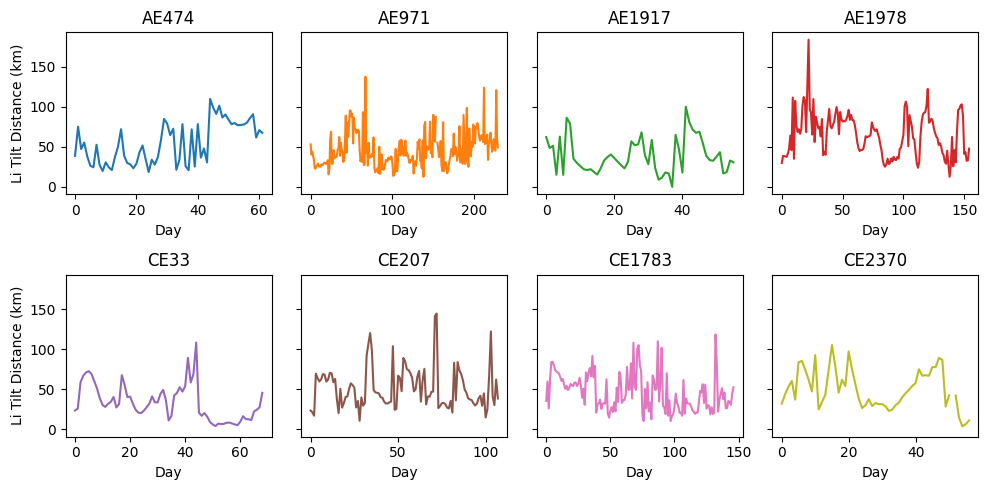

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)

for e, eddy in enumerate(dic_sample.keys()):
    ax = axs[e // 4, e % 4]
    dic = dic_sample[eddy]
    days = sorted(dic.keys())
    TDis = []
    for day in days:
        df = dic[day]
        if len(df):
            td, th, _ = tilt_distance_LI(df.x.values, df.y.values, -df.Depth.values)
            TDis.append(td)
        else:
            TDis.append(np.nan)
    ax.plot(range(len(TDis)), TDis, color=colors[e % 10])
    cyc = df_eddies[df_eddies.Eddy==int(eddy[4:])].iloc[0].Cyc
    ax.set_title(f'{cyc}{int(eddy[4:])}')
    ax.set_xlabel('Day')
axs[0,0].set_ylabel('Li Tilt Distance (km)')
axs[1,0].set_ylabel('Li Tilt Distance (km)')
plt.tight_layout()


### Regs Tilt

In [10]:
for e, eddy in enumerate(sample_eddies):
    dic = dic_eddies_vert[f'Eddy{eddy}']
    df = compute_tilt_data(dic, eddy)
    if e == 0:
        df_tilt_data = df
    else:
        df_tilt_data = pd.concat([df_tilt_data, df], ignore_index=True)
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)

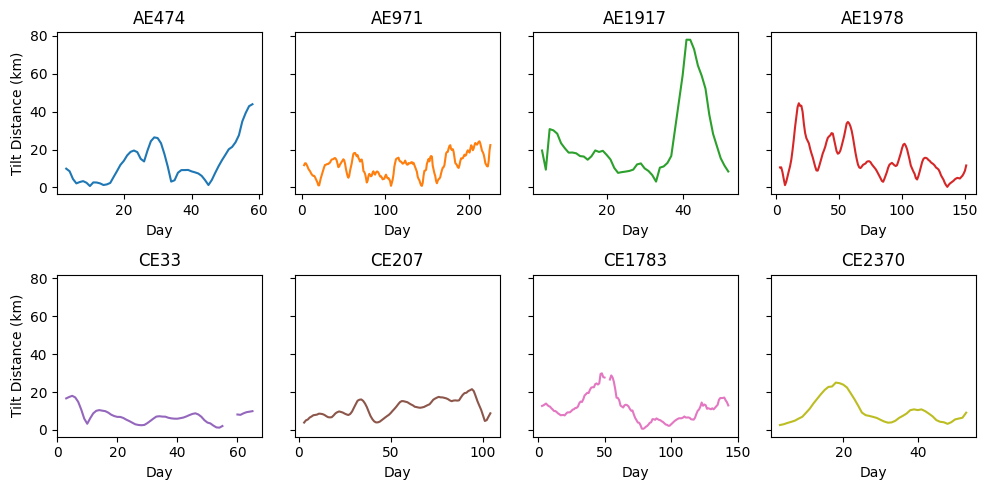

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy==eddy]
    ax.plot(np.arange(len(df)), df.TiltDis, color=colors[e])
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    ax.set_xlabel('Day')
axs[0,0].set_ylabel('Tilt Distance (km)')
axs[1,0].set_ylabel('Tilt Distance (km)')
plt.tight_layout()


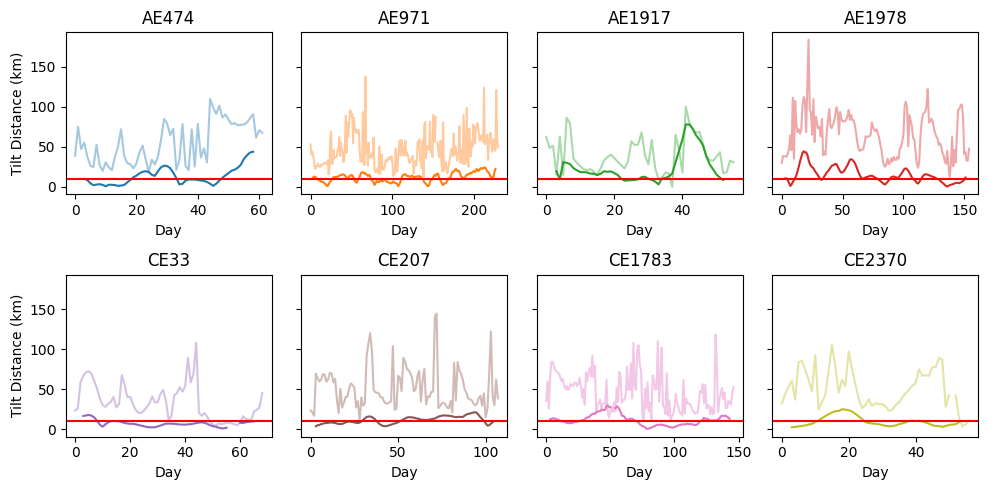

In [12]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)

for e, eddy in enumerate(dic_sample.keys()):
    ax = axs[e // 4, e % 4]
    dic = dic_sample[eddy]
    days = sorted(dic.keys())
    TDis = []
    for day in days:
        df = dic[day].copy()
        # df = df[df.Depth.abs() <=300]
        if len(df):
            td, th, _ = tilt_distance_LI(df.x.values, df.y.values, -df.Depth.values)
            TDis.append(td)
        else:
            TDis.append(np.nan)
    ax.plot(range(len(TDis)), TDis, color=colors[e % 10], alpha=.4)
    df = df_eddies[df_eddies.Eddy==int(eddy[4:])]
    ax.plot(np.arange(len(df)), df.TiltDis, color=colors[e])
    cyc = df_eddies[df_eddies.Eddy==int(eddy[4:])].iloc[0].Cyc
    ax.set_title(f'{cyc}{int(eddy[4:])}')
    ax.set_xlabel('Day')
    ax.axhline(y=10, color='r')
axs[0,0].set_ylabel('Tilt Distance (km)')
axs[1,0].set_ylabel('Tilt Distance (km)')

plt.tight_layout()


In [13]:
df_sample = df_eddies[df_eddies.Eddy.isin(sample_eddies)]
df_sample.TiltDis.max()

np.float64(78.02835192854583)

In [14]:
np.nanmean(df_sample.TiltDis)

np.float64(12.658673724365318)

#### My Tilt Breakdown

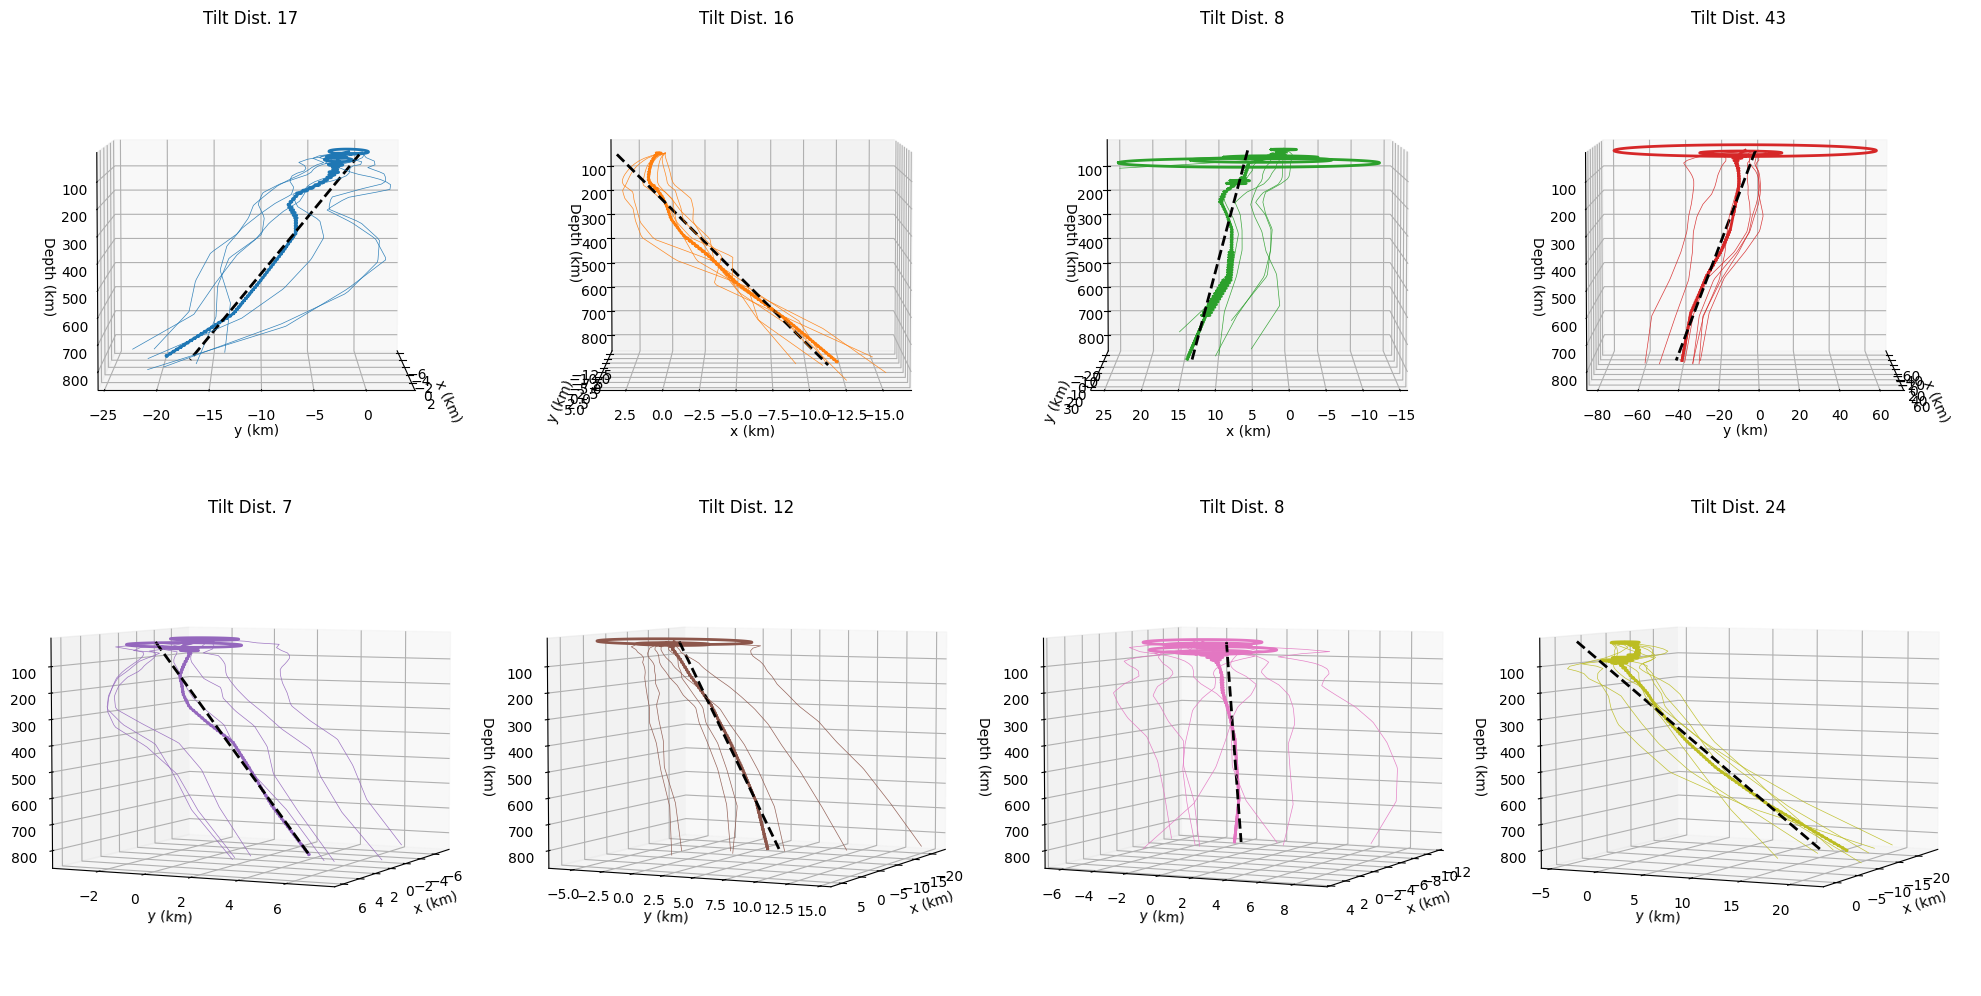

In [15]:
from mpl_toolkits.mplot3d import Axes3D 

# Create a 2x4 grid of 3D subplots
fig = plt.figure(figsize=(20, 10))  # make it wide and tall enough
axes = []

ref_days = [50, 40, 52, 20, 
            20, 30, 20, 20]
azims = [0, 90, 90, 0,
         25, 25, 25, 25]

for e, (eddy, ref_day) in enumerate(zip(sample_eddies, ref_days)):
    dic = dic_eddies_vert[f'Eddy{eddy}']
    num = 6
    depth_int = 10
    max_depth = 1000
    
    df_tilt_data = pd.DataFrame(columns=['Eddy', 'Day', 'TiltDis', 'TiltDir'])
    
    diffs_x = {}
    diffs_y = {}
    df_x_interp = {}
    df_y_interp = {}
        
    for d, day in enumerate(dic.keys()):
    
        df = dic[day].copy()
        df['Depth'] = -df['Depth']
        df = df[df['Depth'] <= max_depth]
        # don’t drop rows — keep all depths, even if x or y are NaN
        df = df.set_index('Depth').sort_index()
    
        if len(df):
            depths = df.index.values
            # interpolate at every 10 m from 0 to max_depth
            target_depths = np.arange(0, max_depth+1, depth_int)
            valid = target_depths[
                (target_depths >= depths.min()) &
                (target_depths <= depths.max())
            ]
            if len(valid) < 2:
                continue
        
            x_i = np.interp(valid, depths, df['x'].values, left=np.nan, right=np.nan)
            y_i = np.interp(valid, depths, df['y'].values, left=np.nan, right=np.nan)
    
            df_x_interp[f'$t_{{{d}}}$'] = pd.Series(x_i, index=valid)
            df_y_interp[f'$t_{{{d}}}$'] = pd.Series(y_i, index=valid)
        
            dx = np.diff(x_i)
            dy = np.diff(y_i)
        
            # use the actual depth levels (valid[:-1]) as the Series index
            idx = valid[:-1]
            diffs_x[f'$t_{{{d}}}$'] = pd.Series(dx, index=idx)
            diffs_y[f'$t_{{{d}}}$'] = pd.Series(dy, index=idx)
    
        else:
            idx = [depth_int]
            diffs_x[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            diffs_y[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
    
            df_x_interp[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            df_y_interp[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            
    # now construct your DataFrames simply by passing the dict-of-series:
    df_X_all = pd.DataFrame(diffs_x)
    df_Y_all = pd.DataFrame(diffs_y)
    
    df_x_interp_all = pd.DataFrame(df_x_interp)
    df_y_interp_all = pd.DataFrame(df_y_interp)
    
    df_X = df_X_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    df_Y = df_Y_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    
    df_x_interp = df_x_interp_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    df_y_interp = df_y_interp_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    
    # Calculation of variability at each depth
    df_data = pd.DataFrame()
    df_data[r'$\Delta x$'] = df_X.mean(axis=1)
    df_data[r'$\Delta y$'] = df_Y.mean(axis=1)
    df_data[r'$\sum{\Delta x}$'] = df_data[r'$\Delta x$'].cumsum()
    df_data[r'$\sum{\Delta y}$'] = df_data[r'$\Delta y$'].cumsum()
    df_data[r'$\sigma^2_{\Delta x}$'] = df_X.var(axis=1)
    df_data[r'$\sigma^2_{\Delta y}$'] = df_Y.var(axis=1)
    df_data[r'Total $\sigma^2$'] = df_data[r'$\sigma^2_{\Delta x}$'] + df_data[r'$\sigma^2_{\Delta y}$']
    df_data['weight'] = 1 / df_data[r'Total $\sigma^2$']
    df_data['Depth'] = df_data.index 
    df_data
    
    # Line of Best Fit
    
    # your data arrays of shape (N,)
    x = df_data[r'$\sum{\Delta x}$'].values
    y = df_data[r'$\sum{\Delta y}$'].values
    z = df_data['Depth'].values
    w = df_data['weight'].values
    
    # 1. compute weighted mean
    W = np.sum(w)
    mean = np.array([np.dot(w, x),
                     np.dot(w, y),
                     np.dot(w, z)]) / W
    
    # 2. center and weight the data
    X = np.vstack((x, y, z)).T
    Xc = X - mean
    Xw = Xc * np.sqrt(w)[:, None]
    
    # 3. SVD on weighted, centered data
    try:
        flag = 0
        _, _, Vt = np.linalg.svd(Xw, full_matrices=False)
    except Exception:
        flag = 1
        # print(f"Eddy{eddy} on day {list(dic.keys())[ref_day][3:]} did not have a measurable profile")
        
    if flag:
        
        df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': ref_day, 'TiltDis': np.nan, 'TiltDir': np.nan}
        
    else:
        
        direction = Vt[0]   # principal axis
        
        # The best-fit line is:  p(t) = mean + t * direction
        t = np.linspace((np.max(z)-mean[2])/direction[2], (np.min(z)-mean[2])/direction[2], 2)            # shape (100,)
        p = mean[None, :] + t[:, None] * direction  # shape (100,3)
        # or equivalently
        p = mean + np.outer(t, direction)          # also (100,3)
        
        # then split back out if you need x,y,z separately:
        x_line, y_line, z_line = p.T
        
        tilt_dist = np.hypot(x_line[0]-x_line[1], y_line[0]-y_line[1])
        
        top_idx = np.where(np.abs(z_line)==np.min(np.abs(z_line)))[0][0]
        if top_idx == 1:
            btm_idx = 0
        else:
            btm_idx = 1
        top = [x_line[top_idx], y_line[top_idx], z_line[top_idx]]
        btm = [x_line[btm_idx], y_line[btm_idx], z_line[btm_idx]]
        tilt_direc = ( bearing(btm, top) + 20 ) % 360
    
        df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': ref_day, 'TiltDis': tilt_dist, 'TiltDir': tilt_direc}

        ax = fig.add_subplot(2, 4, e+1, projection='3d')
        axes.append(ax)

        y = df_x_interp.index.to_numpy()
        
        for t in range(df_x_interp.shape[1]):
            xt = (df_x_interp.iloc[:, t] - df_x_interp.iloc[0, t]).to_numpy()
            yt = (df_y_interp.iloc[:, t] - df_y_interp.iloc[0, t]).to_numpy()
            ax.plot(xt, yt, y, alpha=.9, lw=.5, color=colors[e])
            if t == 3:
                xmu = df_data[r'$\sum{\Delta x}$'].to_numpy()
                ymu = df_data[r'$\sum{\Delta y}$'].to_numpy()
                d   = df_data['Depth'].to_numpy()
                tvar = df_data[r'Total $\sigma^2$'].to_numpy()
        
                ax.plot(xmu, ymu, d, color=colors[e], lw=2)
        
                theta = np.linspace(0, 2*np.pi, 100)
                for xm, ym, dm, rv in zip(xmu, ymu, d, tvar):
                    cx = xm + rv*np.cos(theta)
                    cy = ym + rv*np.sin(theta)
                    cz = np.full_like(cx, dm)
                    ax.plot(cx, cy, cz, lw=2, color=colors[e])
        
                ax.plot([top[0], btm[0]], [top[1], btm[1]], [top[2], btm[2]], color='k', ls='--', lw=2)
        
        ax.invert_zaxis()
        
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')
        ax.set_zlabel('Depth (km)')
        
        ax.view_init(elev=5, azim=azims[e])
        ax.set_title(f'Tilt Dist. {round(tilt_dist)}')
    
plt.tight_layout()
plt.show()


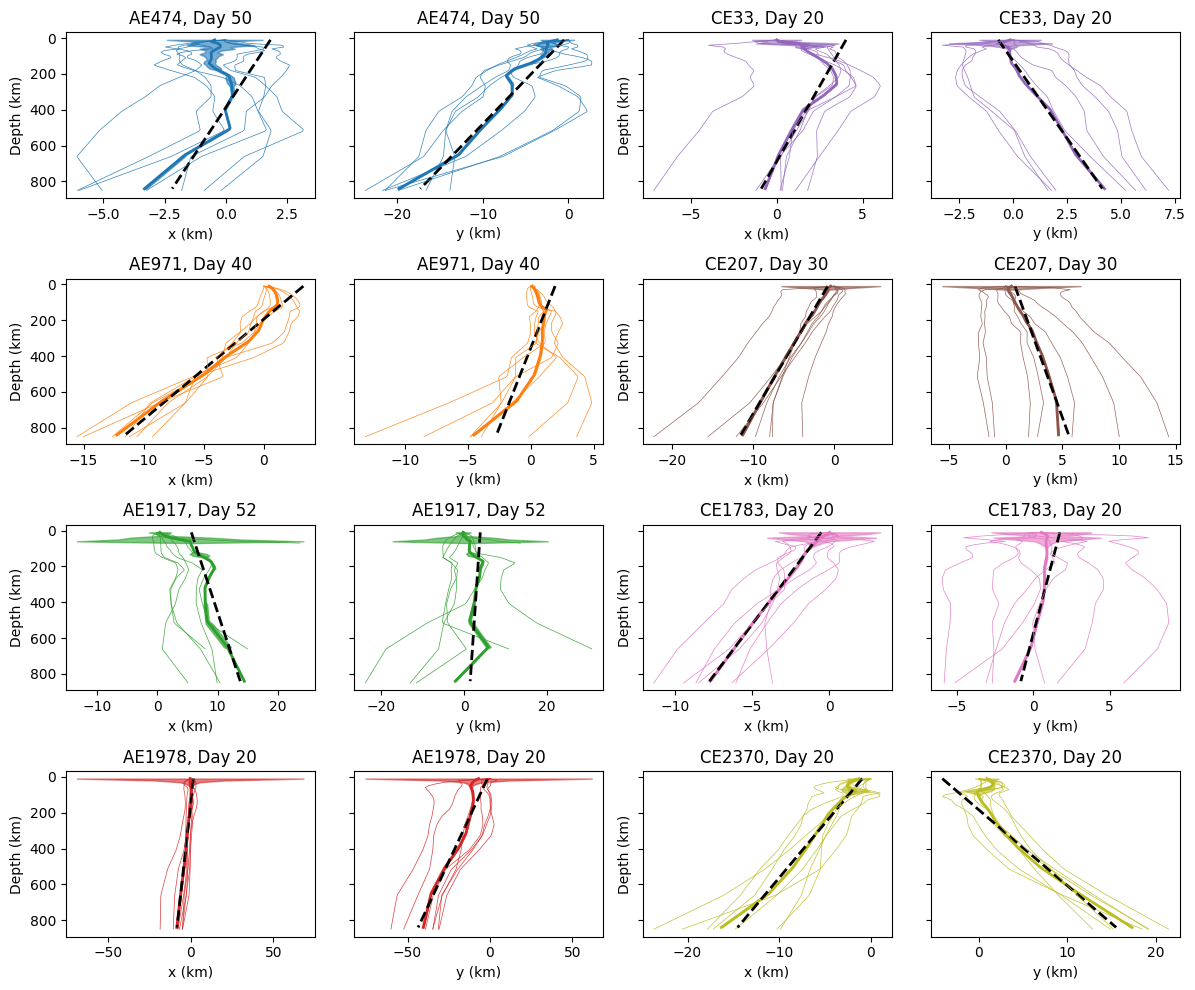

In [16]:
fig, axs = plt.subplots(4, 4, figsize=(12,10), sharey=True)

ref_days = [50, 40, 52, 20, 
            20, 30, 20, 20]
for e, (eddy, ref_day) in enumerate(zip(sample_eddies, ref_days)):
    ax0 = axs[e % 4, (e//4)*2]
    ax1 = axs[e % 4, 1+(e//4)*2]
    
    dic = dic_eddies_vert[f'Eddy{eddy}']
    num = 6
    depth_int = 10
    max_depth = 1000
    
    df_tilt_data = pd.DataFrame(columns=['Eddy', 'Day', 'TiltDis', 'TiltDir'])
    
    diffs_x = {}
    diffs_y = {}
    df_x_interp = {}
    df_y_interp = {}
        
    for d, day in enumerate(dic.keys()):
    
        df = dic[day].copy()
        df['Depth'] = -df['Depth']
        df = df[df['Depth'] <= max_depth]
        # don’t drop rows — keep all depths, even if x or y are NaN
        df = df.set_index('Depth').sort_index()
    
        if len(df):
            depths = df.index.values
            # interpolate at every 10 m from 0 to max_depth
            target_depths = np.arange(0, max_depth+1, depth_int)
            valid = target_depths[
                (target_depths >= depths.min()) &
                (target_depths <= depths.max())
            ]
            if len(valid) < 2:
                continue
        
            x_i = np.interp(valid, depths, df['x'].values, left=np.nan, right=np.nan)
            y_i = np.interp(valid, depths, df['y'].values, left=np.nan, right=np.nan)
    
            df_x_interp[f'$t_{{{d}}}$'] = pd.Series(x_i, index=valid)
            df_y_interp[f'$t_{{{d}}}$'] = pd.Series(y_i, index=valid)
        
            dx = np.diff(x_i)
            dy = np.diff(y_i)
        
            # use the actual depth levels (valid[:-1]) as the Series index
            idx = valid[:-1]
            diffs_x[f'$t_{{{d}}}$'] = pd.Series(dx, index=idx)
            diffs_y[f'$t_{{{d}}}$'] = pd.Series(dy, index=idx)
    
        else:
            idx = [depth_int]
            diffs_x[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            diffs_y[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
    
            df_x_interp[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            df_y_interp[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            
    # now construct your DataFrames simply by passing the dict-of-series:
    df_X_all = pd.DataFrame(diffs_x)
    df_Y_all = pd.DataFrame(diffs_y)
    
    df_x_interp_all = pd.DataFrame(df_x_interp)
    df_y_interp_all = pd.DataFrame(df_y_interp)
    
    df_X = df_X_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    df_Y = df_Y_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    
    df_x_interp = df_x_interp_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    df_y_interp = df_y_interp_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    
    # Calculation of variability at each depth
    df_data = pd.DataFrame()
    df_data[r'$\Delta x$'] = df_X.mean(axis=1)
    df_data[r'$\Delta y$'] = df_Y.mean(axis=1)
    df_data[r'$\sum{\Delta x}$'] = df_data[r'$\Delta x$'].cumsum()
    df_data[r'$\sum{\Delta y}$'] = df_data[r'$\Delta y$'].cumsum()
    df_data[r'$\sigma^2_{\Delta x}$'] = df_X.var(axis=1)
    df_data[r'$\sigma^2_{\Delta y}$'] = df_Y.var(axis=1)
    df_data[r'Total $\sigma^2$'] = df_data[r'$\sigma^2_{\Delta x}$'] + df_data[r'$\sigma^2_{\Delta y}$']
    df_data['weight'] = 1 / df_data[r'Total $\sigma^2$']
    df_data['Depth'] = df_data.index 
    df_data
    
    # Line of Best Fit
    
    # your data arrays of shape (N,)
    x = df_data[r'$\sum{\Delta x}$'].values
    y = df_data[r'$\sum{\Delta y}$'].values
    z = df_data['Depth'].values
    w = df_data['weight'].values
    
    # 1. compute weighted mean
    W = np.sum(w)
    mean = np.array([np.dot(w, x),
                     np.dot(w, y),
                     np.dot(w, z)]) / W
    
    # 2. center and weight the data
    X = np.vstack((x, y, z)).T
    Xc = X - mean
    Xw = Xc * np.sqrt(w)[:, None]
    
    # 3. SVD on weighted, centered data
    try:
        flag = 0
        _, _, Vt = np.linalg.svd(Xw, full_matrices=False)
    except Exception:
        flag = 1
        # print(f"Eddy{eddy} on day {list(dic.keys())[ref_day][3:]} did not have a measurable profile")
        
    if flag:
        
        df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': ref_day, 'TiltDis': np.nan, 'TiltDir': np.nan}
        
    else:
        
        direction = Vt[0]   # principal axis
        
        # The best-fit line is:  p(t) = mean + t * direction
        t = np.linspace((np.max(z)-mean[2])/direction[2], (np.min(z)-mean[2])/direction[2], 2)            # shape (100,)
        p = mean[None, :] + t[:, None] * direction  # shape (100,3)
        # or equivalently
        p = mean + np.outer(t, direction)          # also (100,3)
        
        # then split back out if you need x,y,z separately:
        x_line, y_line, z_line = p.T
        
        tilt_dist = np.hypot(x_line[0]-x_line[1], y_line[0]-y_line[1])
        
        top_idx = np.where(np.abs(z_line)==np.min(np.abs(z_line)))[0][0]
        if top_idx == 1:
            btm_idx = 0
        else:
            btm_idx = 1
        top = [x_line[top_idx], y_line[top_idx], z_line[top_idx]]
        btm = [x_line[btm_idx], y_line[btm_idx], z_line[btm_idx]]
        tilt_direc = ( bearing(btm, top) + 20 ) % 360
    
        df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': ref_day, 'TiltDis': tilt_dist, 'TiltDir': tilt_direc}

        # PLOT

        y = df_x_interp.index.to_numpy()
        
        for t in range(df_x_interp.shape[1]):
            xt = (df_x_interp.iloc[:, t] - df_x_interp.iloc[0, t]).to_numpy()
            yt = (df_y_interp.iloc[:, t] - df_y_interp.iloc[0, t]).to_numpy()
            
            ax0.plot(xt, y, alpha=.9, lw=.5, color=colors[e])
            ax1.plot(yt, y, alpha=.9, lw=.5, color=colors[e])

            if t == 3:
                xmu = df_data[r'$\sum{\Delta x}$'].to_numpy()
                ymu = df_data[r'$\sum{\Delta y}$'].to_numpy()
                d   = df_data['Depth'].to_numpy()
                tvar = df_data[r'Total $\sigma^2$'].to_numpy()
        
                theta = np.linspace(0, 2*np.pi, 100)
                cx_mins, cx_maxs, cy_mins, cy_maxs = [], [], [], []
                for xm, ym, dm, rv in zip(xmu, ymu, d, tvar):
                    cx = xm + rv*np.cos(theta)
                    cy = ym + rv*np.sin(theta)
                    cz = np.full_like(cx, dm)

                    cx_mins.append(cx.min())
                    cx_maxs.append(cx.max())
                    cy_mins.append(cy.min())
                    cy_maxs.append(cy.max())
                    
                    # ax0.plot(cx, cz, lw=2, color=colors[e])
                    # ax1.plot(cy, cz, lw=2, color=colors[e])
                ax0.fill_betweenx(d, cx_mins, cx_maxs, color=colors[e], alpha=0.6)
                ax1.fill_betweenx(d, cy_mins, cy_maxs, color=colors[e], alpha=0.6)

                ax0.plot(xmu, d, color=colors[e], lw=2)
                ax1.plot(ymu, d, color=colors[e], lw=2)

                ax0.plot([top[0], btm[0]], [top[2], btm[2]], color='k', ls='--', lw=2)
                ax1.plot([top[1], btm[1]], [top[2], btm[2]], color='k', ls='--', lw=2)

        ax0.set_xlabel('x (km)')
        ax1.set_xlabel('y (km)')
        ax0.set_ylabel('Depth (km)')

        cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
        ax0.set_title(f'{cyc}{eddy}, Day {ref_day}')
        ax1.set_title(f'{cyc}{eddy}, Day {ref_day}')

        # ax0.set_xlim(-50, 50)
        # ax1.set_xlim(-50, 50)

axs[0,0].invert_yaxis()
plt.tight_layout()
plt.show()


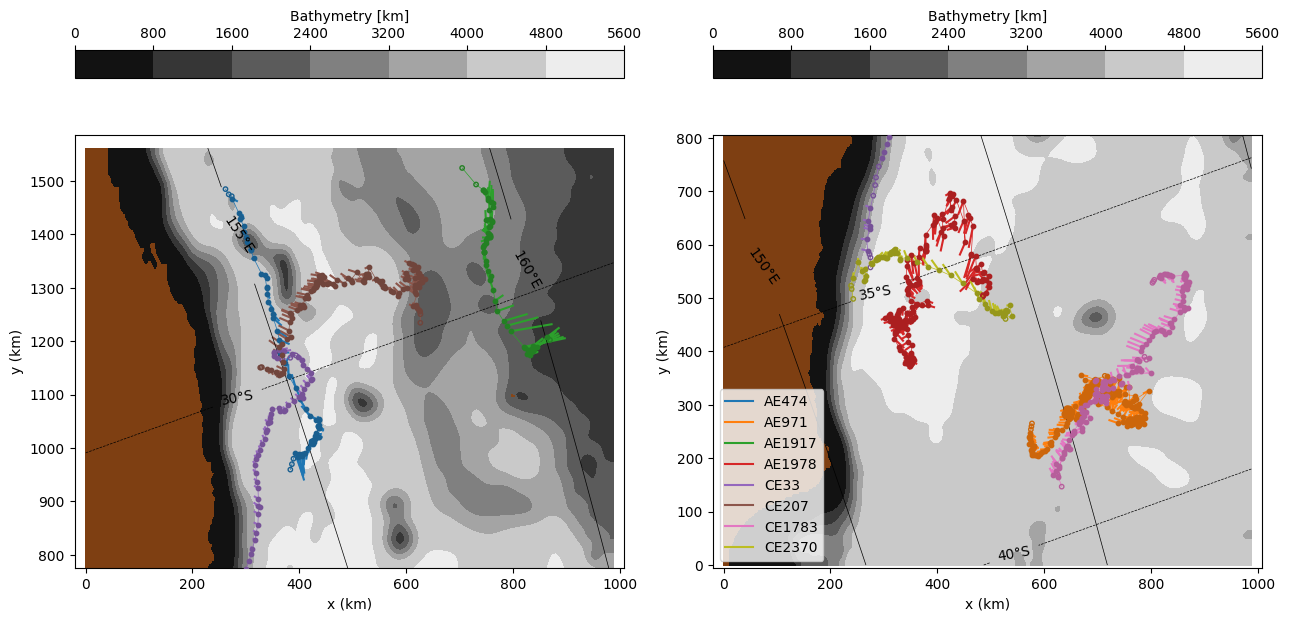

In [65]:
def point_b(a, r, theta_deg):
    theta_rad = np.radians(theta_deg)
    dx = r * np.sin(theta_rad)
    dy = r * np.cos(theta_rad)
    return a[0] - dx, a[1] - dy

from matplotlib.colors import to_rgb
def darken(color, factor=0.7):
    r, g, b = to_rgb(color)
    return (r*factor, g*factor, b*factor)

fig, axs = plt.subplots(1, 2, figsize=(13,6.5))
cf0 = axs[0].contourf(X_grid, Y_grid, h, cmap='gray')
cf1 = axs[1].contourf(X_grid, Y_grid, h, cmap='gray')
# Add horizontal colorbars at the top
fig.colorbar(cf0, ax=axs[0], orientation='horizontal', location='top', pad=0.1, label='Bathymetry [km]')
fig.colorbar(cf1, ax=axs[1], orientation='horizontal', location='top', pad=0.1, label='Bathymetry [km]')

axs[0].contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                  levels=[0.5, 1.5], colors=['saddlebrown'], alpha=.9)
axs[1].contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                  levels=[0.5, 1.5], colors=['saddlebrown'], alpha=.9)

for e, eddy in enumerate(sample_eddies):
    df = df_eddies[df_eddies.Eddy==eddy]
    df_eddy = df_eddies[df_eddies.Eddy==eddy]
    axs[0].plot(df_eddy.xc, df_eddy.yc, color=colors[e], linewidth=.5, zorder=1)
    axs[1].plot(df_eddy.xc, df_eddy.yc, color=colors[e], linewidth=.5, zorder=1)
    for d, day in enumerate(df['Day'].unique()):
        data = df[df.Day==day]
        tilt_dis = data.iloc[0]['TiltDis']
        tilt_dir = data.iloc[0]['TiltDir']
        plot_data = df_eddies[(df_eddies.Eddy==eddy) & (df_eddies['Day']==int(day))]
        x0, y0 = plot_data.iloc[0].xc, plot_data.iloc[0].yc   # FIXED
        xb, yb = point_b([x0, y0], tilt_dis, (tilt_dir-20) % 360)
        axs[0].plot([x0, xb], [y0, yb], color=colors[e], zorder=2)
        cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
        axs[1].plot([x0, xb], [y0, yb], color=colors[e], zorder=2,
                    label=f'{cyc}{eddy}' if d==0 else '')
        if np.isnan(tilt_dis):
            axs[0].scatter(x0, y0, color=darken(colors[e % len(colors)], 0.8),
                           s=10, zorder=3, facecolors='none')
            axs[1].scatter(x0, y0, color=darken(colors[e % len(colors)], 0.8),
                           s=10, zorder=3, facecolors='none')
        else:
            axs[0].scatter(x0, y0, color=darken(colors[e % len(colors)], 0.8),
                           s=10, zorder=3)
            axs[1].scatter(x0, y0, color=darken(colors[e % len(colors)], 0.8),
                           s=10, zorder=3)

c1 = axs[0].contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25],
                      colors='k', linewidths=.5)
axs[0].clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
c2 = axs[0].contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160],
                      colors='k', linewidths=.5)
axs[0].clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

c1 = axs[1].contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25],
                      colors='k', linewidths=.5)
axs[1].clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
c2 = axs[1].contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160],
                      colors='k', linewidths=.5)
axs[1].clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

axs[0].axis('equal')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')
axs[0].set_xlim(X_grid.min(), X_grid.max())
axs[0].set_ylim(800, Y_grid.max())

axs[1].axis('equal')
axs[1].set_xlabel('x (km)')
axs[1].set_ylabel('y (km)')
axs[1].legend(loc='lower left')
axs[1].set_xlim(X_grid.min(), X_grid.max())
axs[1].set_ylim(0, 800)

plt.tight_layout()


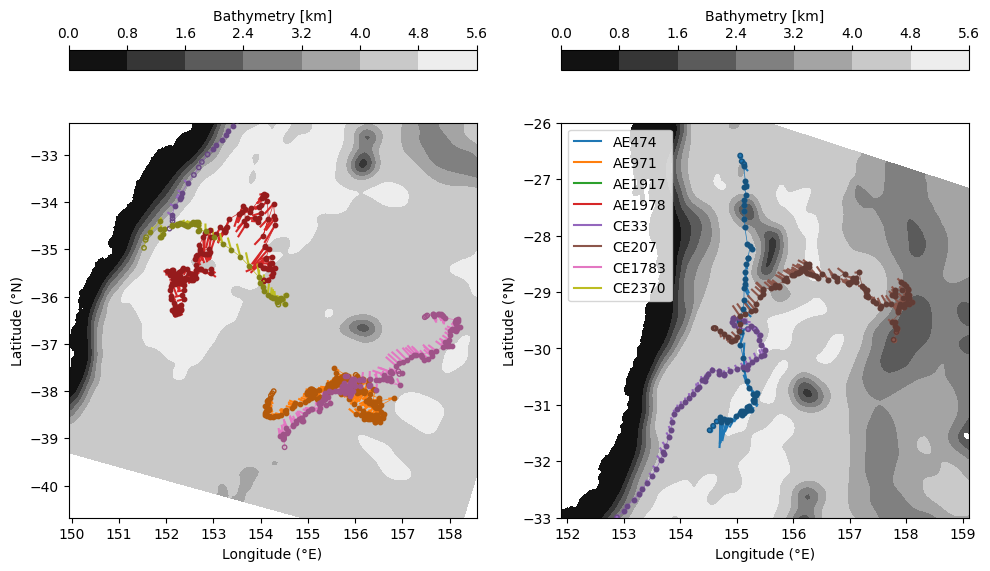

In [89]:
def km_to_deg(km, lat, bearing_deg):
    lat_rad = np.radians(lat)
    bearing_rad = np.radians(bearing_deg)

    # km per degree
    km_per_deg_lat = 111.32
    km_per_deg_lon = 111.32 * np.cos(lat_rad)

    # project distance onto lat/lon directions
    dlat = km * np.sin(bearing_rad) / km_per_deg_lat
    dlon = km * np.cos(bearing_rad) / km_per_deg_lon

    # total angular distance in degrees
    return np.hypot(dlat, dlon)

from matplotlib.colors import to_rgb
def darken(color, factor=0.7):
    r, g, b = to_rgb(color)
    return (r*factor, g*factor, b*factor)


fig, axs = plt.subplots(1, 2, figsize=(10,6))
cf0 = axs[0].contourf(lon_rho, lat_rho, np.where(mask_rho, h/1000, np.nan), cmap='gray')
cf1 = axs[1].contourf(lon_rho, lat_rho, np.where(mask_rho, h/1000, np.nan), cmap='gray')
# Add horizontal colorbars at the top
fig.colorbar(cf0, ax=axs[0], orientation='horizontal', location='top', pad=0.1, label='Bathymetry [km]')
fig.colorbar(cf1, ax=axs[1], orientation='horizontal', location='top', pad=0.1, label='Bathymetry [km]')

for e, eddy in enumerate(sample_eddies):
    df = df_eddies[df_eddies['Eddy']==eddy]
    df_eddy = df_eddies[df_eddies.Eddy==eddy]
    axs[0].plot(df_eddy['Lon'], df_eddy['Lat'], color=colors[e], linewidth=.5)
    axs[1].plot(df_eddy['Lon'], df_eddy['Lat'], color=colors[e], linewidth=.5, marker='.')
    for d, day in enumerate(df['Day'].unique()):
        data = df[df['Day']==day]
        tilt_dis = data.iloc[0]['TiltDis']
        tilt_dir = data.iloc[0]['TiltDir']
        plot_data = df_eddies[(df_eddies.Eddy==eddy) & (df_eddies['Day']==int(day))]
        elon, elat = plot_data.iloc[0]['Lon'], plot_data.iloc[0]['Lat']
        lon_btm, lat_btm = point_b([elon, elat], km_to_deg(tilt_dis, elat, (tilt_dir + 180) % 360), tilt_dir)
        axs[0].plot([elon, lon_btm], [elat, lat_btm], color=colors[e], zorder=2)
        cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0]['Cyc']
        axs[1].plot([elon, lon_btm], [elat, lat_btm], color=colors[e], zorder=2, label=f'{cyc}{eddy}' if d==0 else '')
        if np.isnan(tilt_dis):
            axs[0].scatter(elon, elat, color=darken(colors[e % len(colors)], 0.7), s=10, zorder=3, facecolors='none')#, edgecolor='k')
            axs[1].scatter(elon, elat, color=darken(colors[e % len(colors)], 0.7), s=10, zorder=3, facecolors='none')#, edgecolor='k')
        else:
            axs[0].scatter(elon, elat, color=darken(colors[e % len(colors)], 0.7), s=10, zorder=3)#, edgecolor='k')
            axs[1].scatter(elon, elat, color=darken(colors[e % len(colors)], 0.7), s=10, zorder=3)#, edgecolor='k')
axs[0].axis('equal')
axs[0].set_xlim(150, 158.5)
axs[0].set_ylim(-40, -33)
axs[0].set_xlabel('Longitude (°E)')
axs[0].set_ylabel('Latitude (°N)')

axs[1].axis('equal')
axs[1].set_ylim(-33, -26)
axs[1].set_xlim(152, 159)
axs[1].set_xlabel('Longitude (°E)')
axs[1].set_ylabel('Latitude (°N)')
axs[1].legend()

plt.tight_layout()


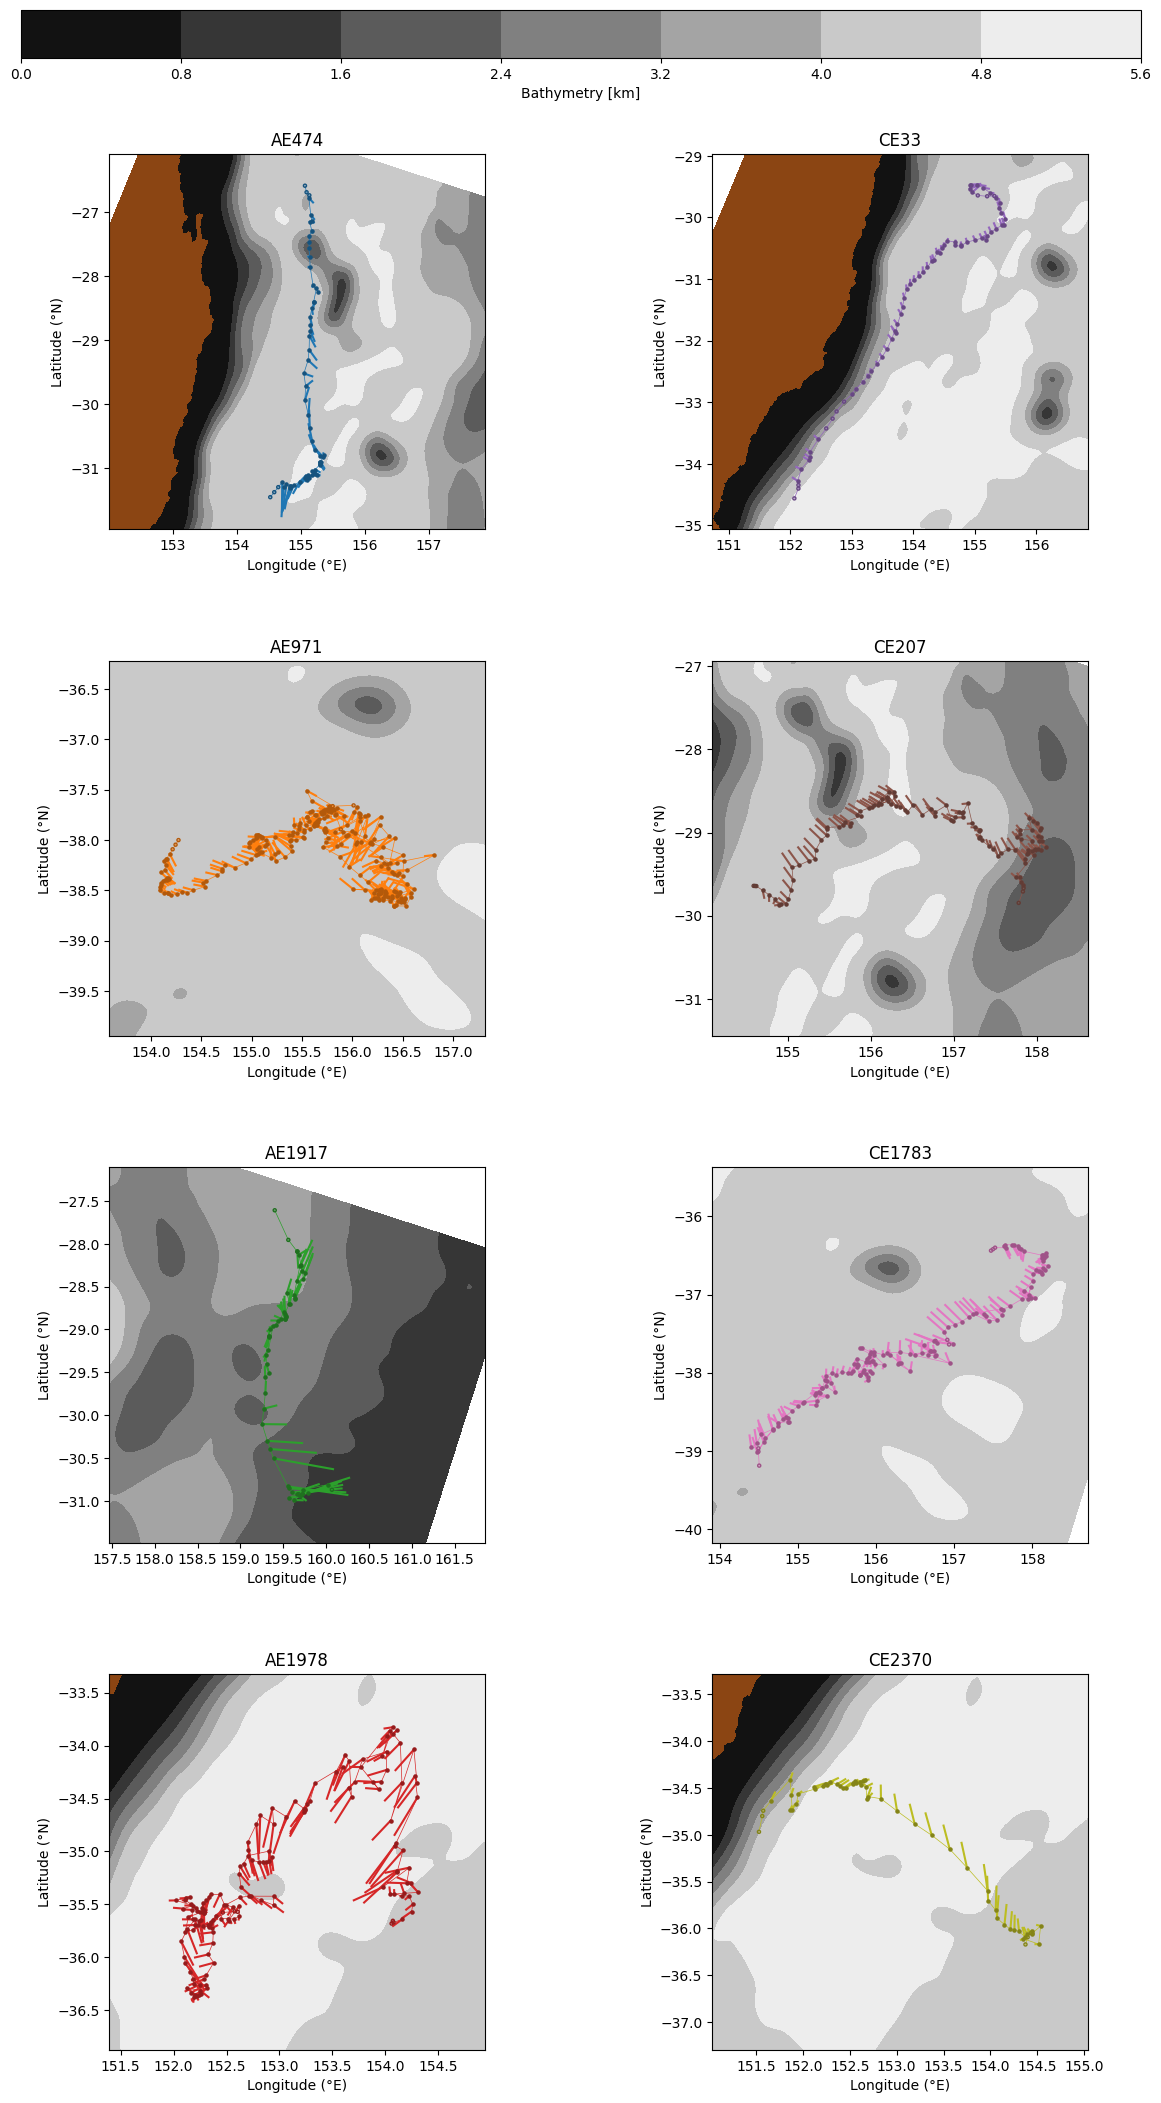

In [115]:
# 1) Build a fixed 4x2 grid (no constrained_layout)
fig, axs = plt.subplots(4, 2, figsize=(14, 24))

# 2) Add a dedicated colorbar axis at the very top (so it won't squeeze subplots)
cbar_ax = fig.add_axes([0.10, 0.94, 0.80, 0.02])  # [left, bottom, width, height] in figure coords

for e, eddy in enumerate(sample_eddies):

    ax = axs[e % 4, e //4]
    df = df_eddies[df_eddies['Eddy'] == eddy].copy()
    cyc = df.iloc[0].Cyc

    # background bathymetry
    cf0 = ax.contourf(lon_rho, lat_rho, h/1000, cmap='gray')
    ax.contourf(lon_rho, lat_rho, np.where(mask_rho == 0, 1, np.nan),
                levels=[0.5, 1.5], colors=['saddlebrown'], alpha=1)

    # track + tilt
    ax.plot(df['Lon'], df['Lat'], color=colors[e], lw=.5)
    for d, day in enumerate(df['Day'].unique()):
        data = df[df['Day'] == day].iloc[0]
        tilt_dis, tilt_dir = data.TiltDis, data.TiltDir
        elon, elat = data['Lon'], data['Lat']
        lon_btm, lat_btm = point_b([elon, elat],
                                   km_to_deg(tilt_dis, elat, (tilt_dir+180) % 360),
                                   tilt_dir)
        ax.plot([elon, lon_btm], [elat, lat_btm], color=colors[e], zorder=2)
        ax.scatter(elon, elat, color=darken(colors[e], 0.7), s=5, zorder=3,
                   facecolors='none' if np.isnan(tilt_dis) else None)

    # zoom to this eddy
    margin = .5
    ax.set_xlim(df['Lon'].min()-margin, df['Lon'].max()+margin)
    ax.set_ylim(df['Lat'].min()-margin, df['Lat'].max()+margin)

    # 3) Make all panels the same physical size
    ax.set_aspect('equal', adjustable='box')  # preserve an equal scale
    ax.set_box_aspect(1)                      # square plotting box for every axes
    ax.set_anchor('C')                        # centre the data region

    ax.set_title(f"{cyc}{eddy}")
    ax.set_xlabel('Longitude (°E)')
    ax.set_ylabel('Latitude (°N)')

# remove any unused axes
for j in range(len(sample_eddies), len(axs)):
    fig.delaxes(axs[j])

# draw the shared colorbar in its own axis (doesn't affect subplot layout)
fig.colorbar(cf0, cax=cbar_ax, orientation='horizontal', label='Bathymetry [km]')

# tidy spacing under the colorbar
fig.subplots_adjust(top=.9, wspace=0.25, hspace=0.35)
plt.show()



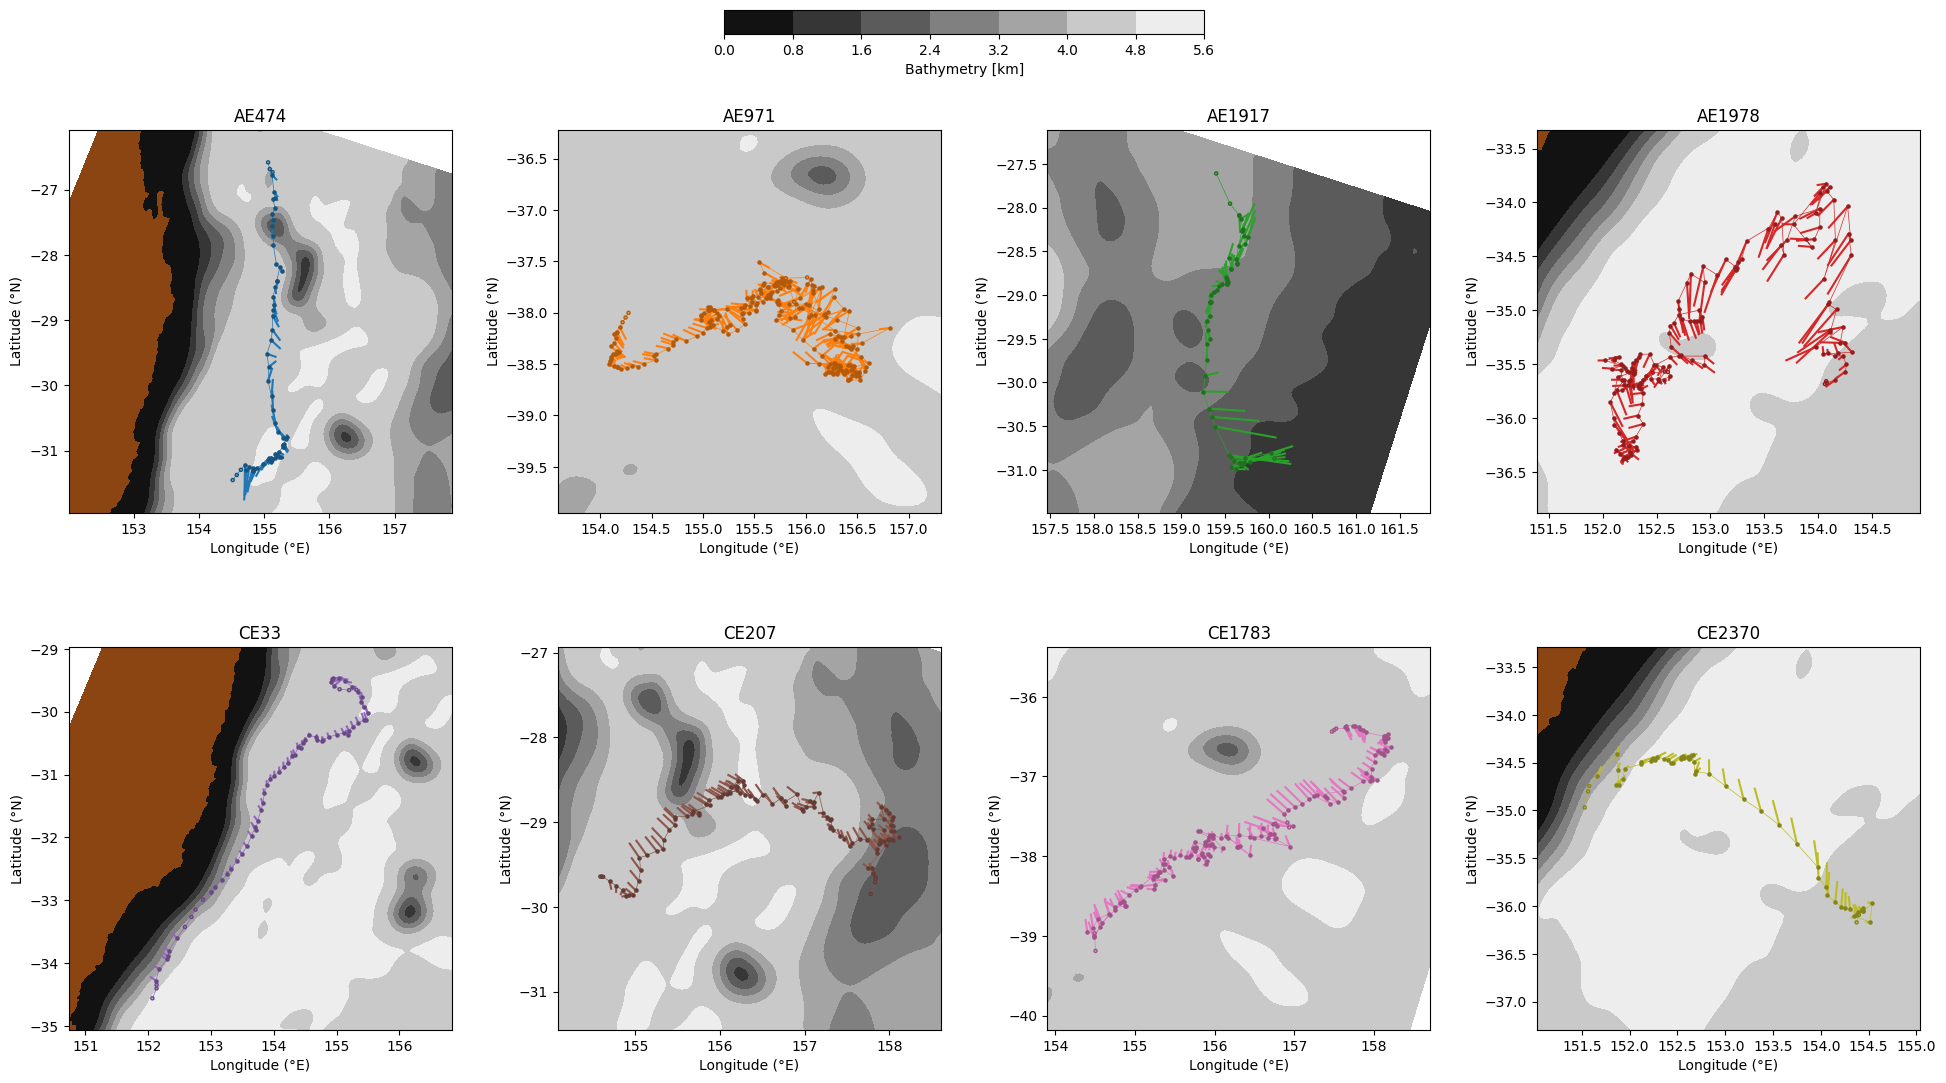

In [125]:
# 1) Build a fixed 4x2 grid (no constrained_layout)
fig, axs = plt.subplots(2, 4, figsize=(24, 12))

# 2) Add a dedicated colorbar axis at the very top (so it won't squeeze subplots)
cbar_ax = fig.add_axes([0.40, 0.94, 0.20, 0.02])  # [left, bottom, width, height] in figure coords

for e, eddy in enumerate(sample_eddies):

    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies['Eddy'] == eddy].copy()
    cyc = df.iloc[0].Cyc

    # background bathymetry
    cf0 = ax.contourf(lon_rho, lat_rho, h/1000, cmap='gray')
    ax.contourf(lon_rho, lat_rho, np.where(mask_rho == 0, 1, np.nan),
                levels=[0.5, 1.5], colors=['saddlebrown'], alpha=1)

    # track + tilt
    ax.plot(df['Lon'], df['Lat'], color=colors[e], lw=.5)
    for d, day in enumerate(df['Day'].unique()):
        data = df[df['Day'] == day].iloc[0]
        tilt_dis, tilt_dir = data.TiltDis, data.TiltDir
        elon, elat = data['Lon'], data['Lat']
        lon_btm, lat_btm = point_b([elon, elat],
                                   km_to_deg(tilt_dis, elat, (tilt_dir+180) % 360),
                                   tilt_dir)
        ax.plot([elon, lon_btm], [elat, lat_btm], color=colors[e], zorder=2)
        ax.scatter(elon, elat, color=darken(colors[e], 0.7), s=5, zorder=3,
                   facecolors='none' if np.isnan(tilt_dis) else None)

    # zoom to this eddy
    margin = .5
    ax.set_xlim(df['Lon'].min()-margin, df['Lon'].max()+margin)
    ax.set_ylim(df['Lat'].min()-margin, df['Lat'].max()+margin)

    # 3) Make all panels the same physical size
    ax.set_aspect('equal', adjustable='box')  # preserve an equal scale
    ax.set_box_aspect(1)                      # square plotting box for every axes
    ax.set_anchor('C')                        # centre the data region

    ax.set_title(f"{cyc}{eddy}")
    ax.set_xlabel('Longitude (°E)')
    ax.set_ylabel('Latitude (°N)')

# remove any unused axes
for j in range(len(sample_eddies), len(axs)):
    fig.delaxes(axs[j])

# draw the shared colorbar in its own axis (doesn't affect subplot layout)
fig.colorbar(cf0, cax=cbar_ax, orientation='horizontal', label='Bathymetry [km]')

# tidy spacing under the colorbar
fig.subplots_adjust(top=.86, wspace=0.25, hspace=0.35)
plt.show()


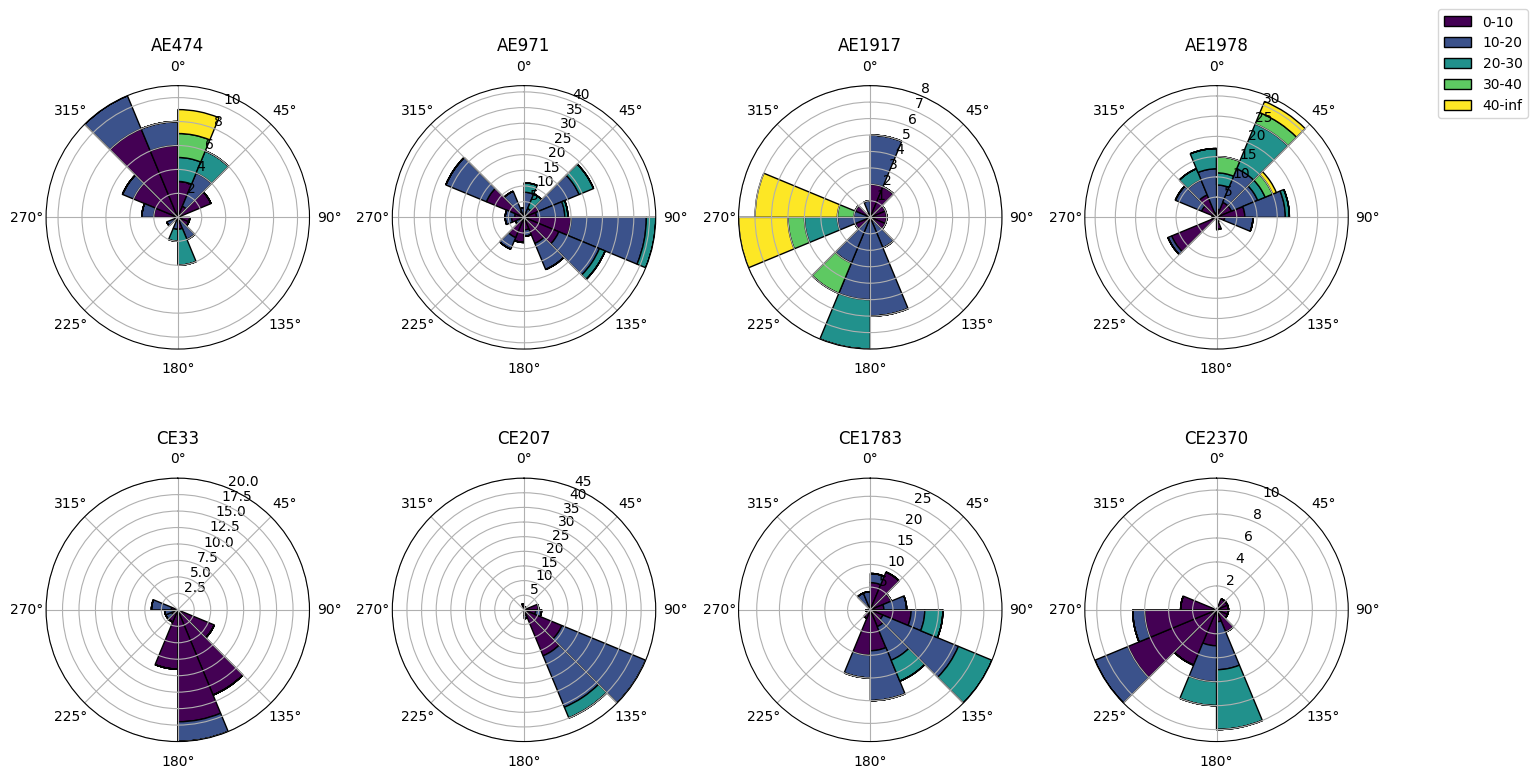

In [19]:
fig, axs = plt.subplots(2, 4, figsize=(14, 8),
                        subplot_kw={'projection': 'polar'},
                        sharex=True)

axs = axs.flatten()

for e, eddy in enumerate(sample_eddies[:8]):  # limit to 8 eddies
    ax = axs[e]

    df = df_eddies[df_eddies.Eddy == eddy].copy()
    directions = df.TiltDir
    magnitudes = df.TiltDis
    
    # Define bins
    dir_bins = np.linspace(0, 360, 17)  # 16 directional sectors
    mag_bins = [0, 10, 20, 30, 40, np.inf]
    
    # Digitise
    dir_idx = np.digitize(directions, dir_bins) - 1
    mag_idx = np.digitize(magnitudes, mag_bins) - 1
    
    # Count occurrences per bin
    counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
    for d, m in zip(dir_idx, mag_idx):
        if 0 <= d < len(dir_bins)-1 and 0 <= m < len(mag_bins)-1:
            counts[m, d] += 1
    
    # Polar bar plot
    n_dirs = len(dir_bins) - 1
    angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
    width = 2 * np.pi / n_dirs
    bottom = np.zeros(n_dirs)
    colors_wr = plt.cm.viridis(np.linspace(0, 1, len(mag_bins)-1))
    
    for i in range(len(mag_bins)-1):
        ax.bar(angles, counts[i], width, bottom=bottom,
               color=colors_wr[i], edgecolor='k',
               label=f'{mag_bins[i]:.0f}-{mag_bins[i+1]:.0f}')
        bottom += counts[i]
    
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)

# Put one legend outside the grid
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1.0))

plt.tight_layout()
plt.show()




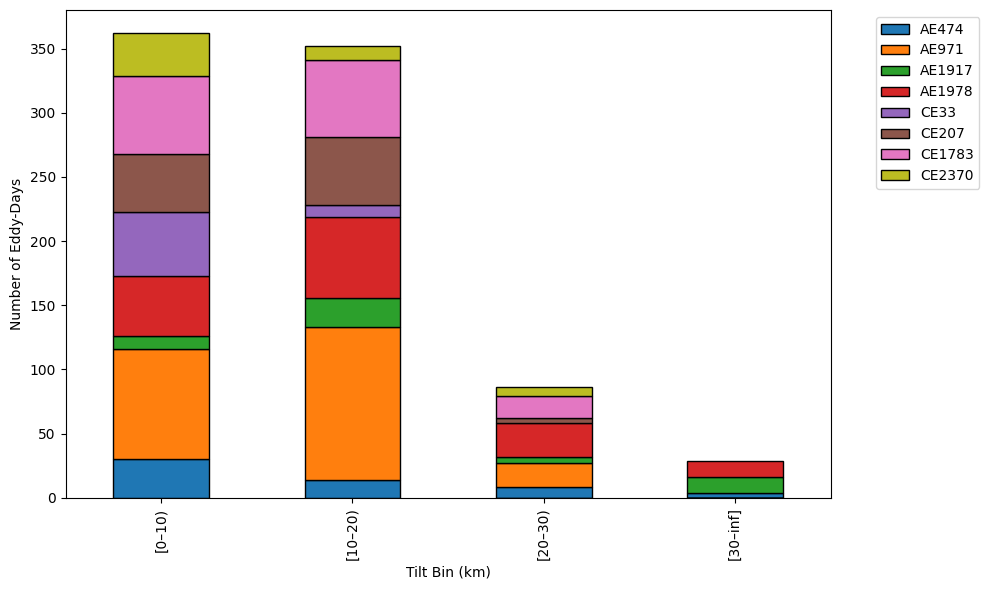

In [20]:
# Adjustable bin width
bin_width = 10  # km
max_depth_km = 40  # adjust as needed

# bins = np.arange(0, max_depth_km + bin_width, bin_width)
bins = [ 0, 10, 20, 30, np.inf]
bin_labels = [f"[{b}–{b+bin_width})" for b in bins[:-2]] \
           + [f"[{bins[-2]}–{bins[-1]}]"]

# Prepare DataFrame
eddies = [int(eddy[4:]) for eddy in list(dic_sample.keys())]
cycs = [df_eddies[df_eddies.Eddy==e].iloc[0].Cyc for e in eddies]
eddy_names = [cycs[k] + str(eddies[k]) for k in range(len(eddies))]

bin_counts = pd.DataFrame(0, index=bin_labels, columns=eddy_names)

for e, eddy in enumerate(sample_eddies):
    df = df_eddies[df_eddies.Eddy == eddy].copy()
    depths = []
    for day in df.Day.unique():
        sub = df[df.Day == day]
        if not sub.empty:
            data = sub.iloc[0]
            depths.append(data.TiltDis)
        else:
            depths.append(np.nan)
    counts, _ = np.histogram(depths, bins=bins)
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    bin_counts.loc[:, f'{cyc}{eddy}'] = counts

# Plot
bin_counts.plot(kind='bar', stacked=True, figsize=(10, 6),
                edgecolor='black', color=colors)
plt.xlabel('Tilt Bin (km)')
plt.ylabel('Number of Eddy-Days')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




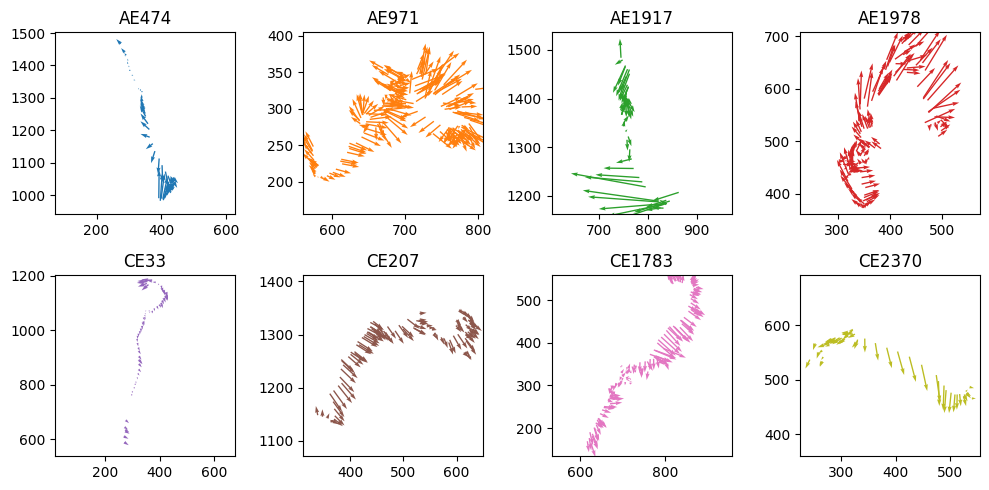

In [21]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy].copy()
    rs = []
    for day in df.Day.unique():
        data = df[df.Day == day].iloc[0]
        r = data.TiltDis
        if not np.isnan(r):
            rs.append(r)
        theta = np.deg2rad(data.TiltDir)  # degrees → radians

        # true north convention
        u = r * np.sin(theta)  # eastward (x)
        v = r * np.cos(theta)  # northward (y)

        ax.quiver(data.xc, data.yc, u, v, angles='xy', scale_units='xy',
                  scale=.5, color=colors[e])

    ax.axis('equal')
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    # ax.set_xlim(-np.nanmax(rs), np.nanmax(rs))
    # ax.set_ylim(-np.nanmax(rs), np.nanmax(rs))

plt.tight_layout()
plt.show()


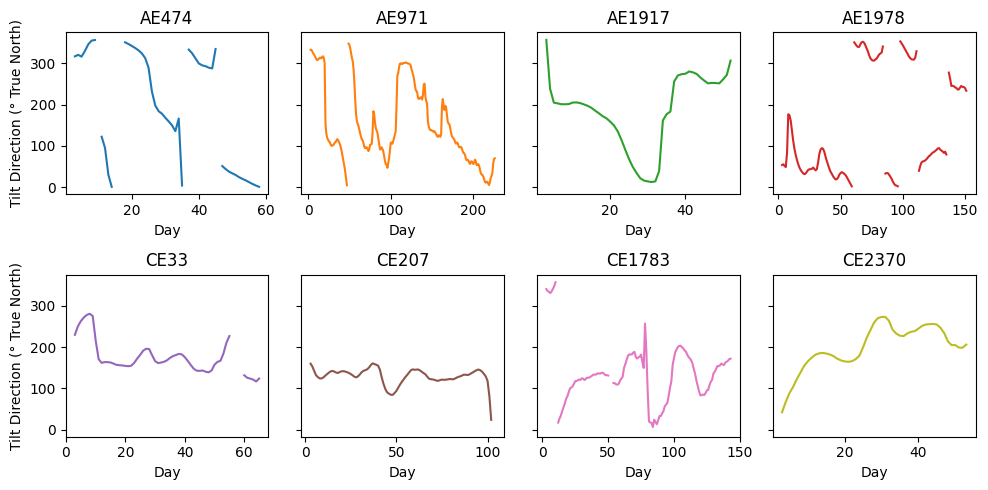

In [59]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy==eddy].copy()
    th = df.TiltDir.to_numpy(dtype=float)
    mag = df.TiltDis.to_numpy(dtype=float)
    t = np.arange(len(df))

    # insert NaN when wrap-around occurs
    diff = np.diff(th, prepend=th[0])
    th[np.abs(diff) > 180] = np.nan

    ax.plot(t, th, color=colors[e])
    # ax.plot(t, mag, color=colors[e], ls='--')
    cyc = df.iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    ax.set_xlabel('Day')

axs[0,0].set_ylabel('Tilt Direction (° True North)')
axs[1,0].set_ylabel('Tilt Direction (° True North)')
plt.tight_layout()
plt.show()


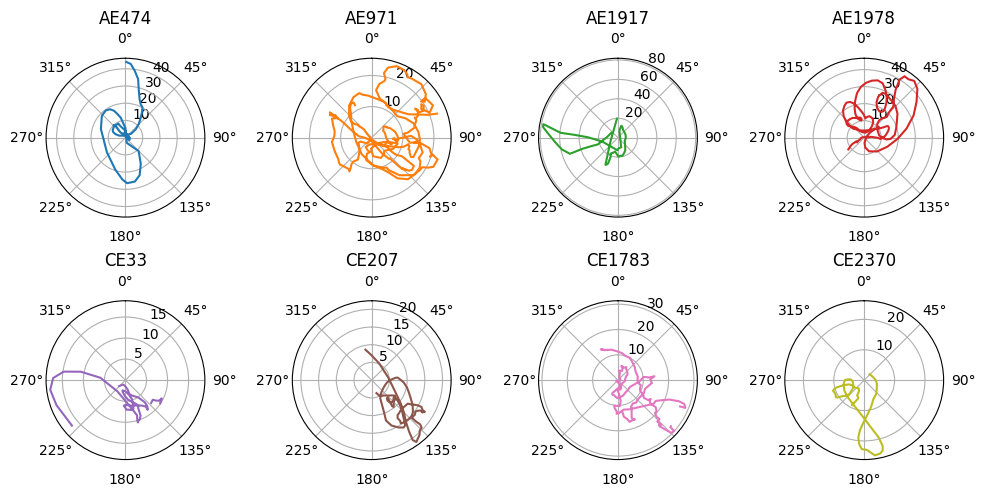

In [128]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5),
                        subplot_kw={'projection': 'polar'})

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = df.TiltDis.to_numpy()
    theta_deg = df.TiltDir.to_numpy()
    phi = np.deg2rad(theta_deg)

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.plot(phi, r, color=colors[e])

    cyc = df.iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')

plt.tight_layout()
plt.show()


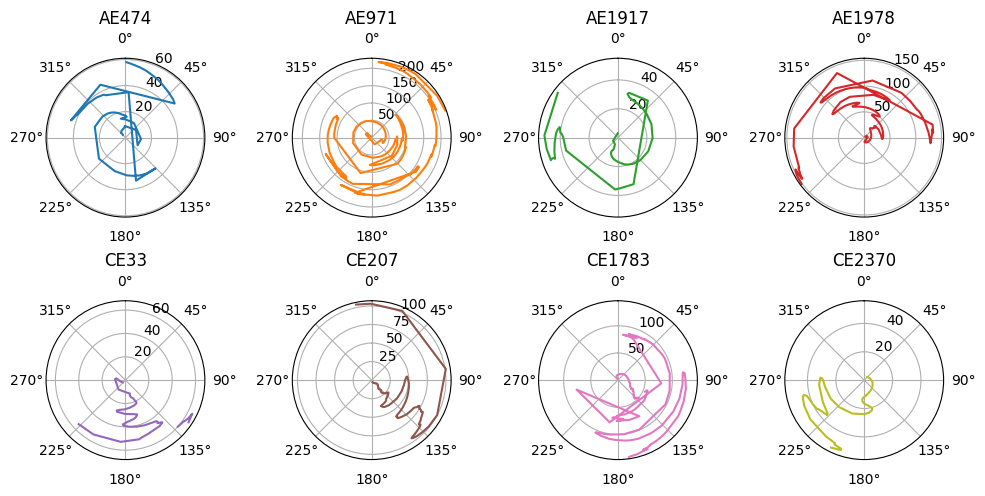

In [24]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), subplot_kw={'projection': 'polar'})

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = np.arange(len(df))
    th = np.deg2rad(df.TiltDir.to_numpy(dtype=float))  # radians for polar plot

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)

    ax.plot(th, r, color=colors[e])

    # --- tighten the radial axis around the data ---
    ax.set_rlim(r.min(), r.max())

    ax.set_title(f"{df.iloc[0].Cyc}{eddy}")

plt.tight_layout()
plt.show()


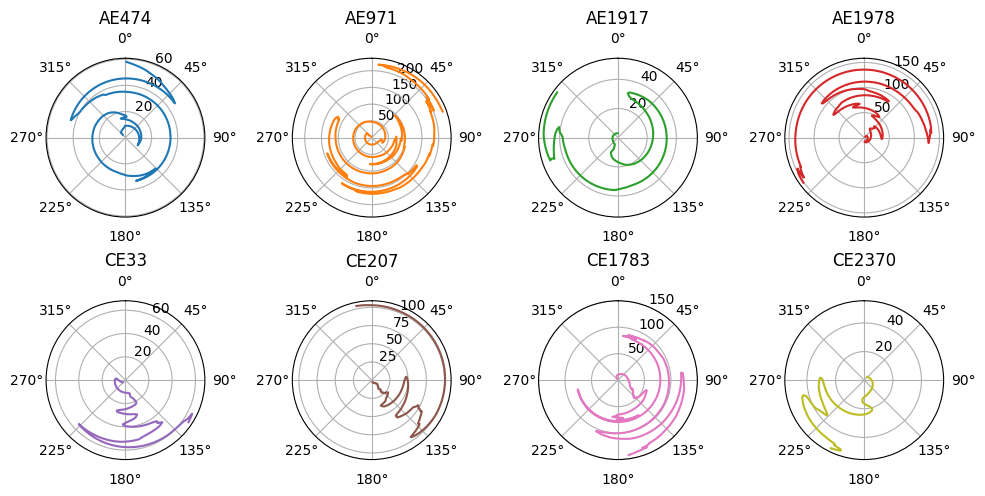

In [25]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), subplot_kw={'projection': 'polar'})

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = np.arange(len(df))
    th = df.TiltDir.to_numpy(dtype=float)
    m = ~np.isnan(th)
    r_new = np.arange(r.min(), r.max(), 0.001)

    th_wrap = np.full_like(r_new, np.nan, dtype=float)
    if m.any() and m.sum() > 1:
        th_unwrap = np.unwrap(np.deg2rad(th[m]), discont=np.deg2rad(180))
        thi = np.interp(r_new, r[m], th_unwrap, left=np.nan, right=np.nan)
        th_wrap = (np.rad2deg(thi)) % 360

    phi = np.deg2rad(th_wrap)

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.plot(phi, r_new, color=colors[e])

    ax.set_title(f"{df.iloc[0].Cyc}{eddy}")

plt.tight_layout()
plt.show()


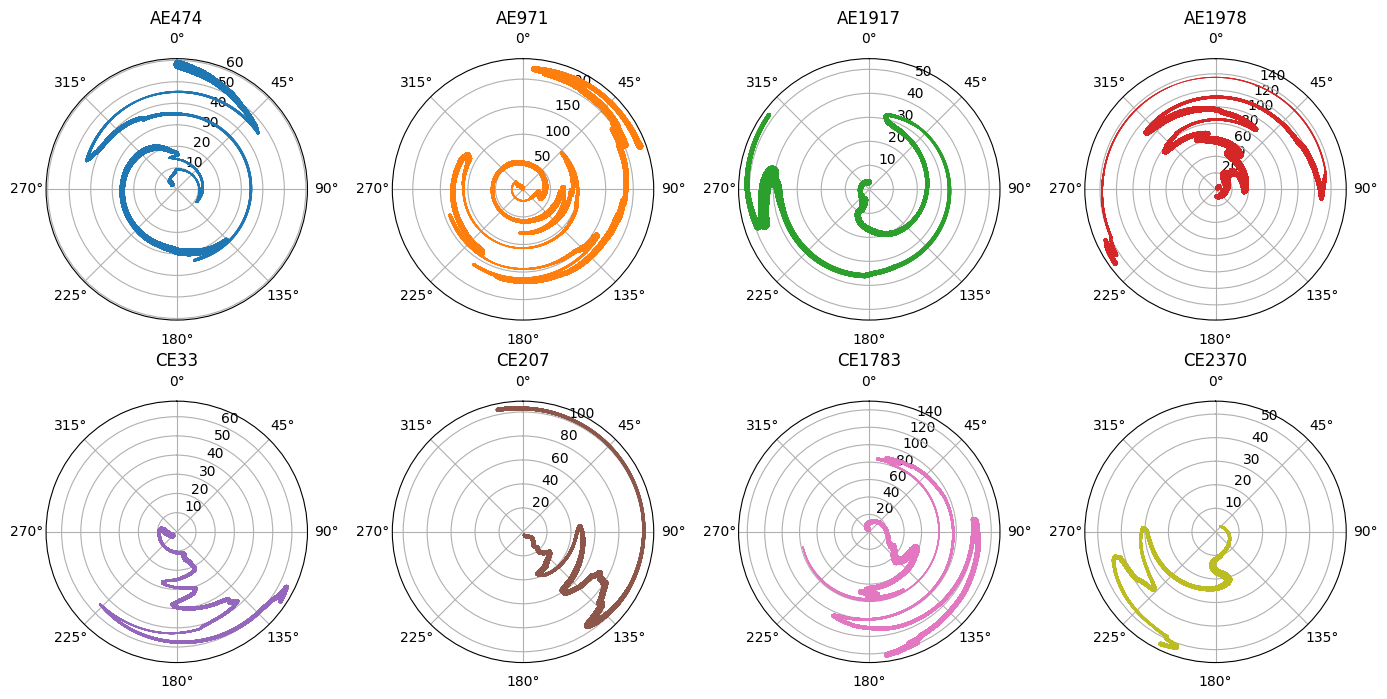

In [26]:
fig, axs = plt.subplots(2, 4, figsize=(14, 7), subplot_kw={'projection': 'polar'})

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = np.arange(len(df))
    th = df.TiltDir.to_numpy(dtype=float)
    mag = df.TiltDis.to_numpy(dtype=float)  # >= 0

    r_new = np.arange(r.min(), r.max(), 0.001)

    # --- angle (unwrap → interp → wrap) ---
    m_th = ~np.isnan(th)
    th_wrap = np.full_like(r_new, np.nan, dtype=float)
    if m_th.sum() > 1:
        th_unwrap = np.unwrap(np.deg2rad(th[m_th]), discont=np.deg2rad(180))
        thi = np.interp(r_new, r[m_th], th_unwrap, left=np.nan, right=np.nan)
        th_wrap = (np.rad2deg(thi)) % 360
    phi = np.deg2rad(th_wrap)

    # --- magnitude (linear interp, no extrapolation) ---
    m_mag = ~np.isnan(mag)
    mag_interp = np.full_like(r_new, np.nan, dtype=float)
    if m_mag.sum() > 1:
        mag_interp = np.interp(r_new, r[m_mag], mag[m_mag], left=np.nan, right=np.nan)
        mag_interp = np.maximum(mag_interp, 0)  # keep non-negative

    # plot only where both are finite
    ok = np.isfinite(phi) & np.isfinite(mag_interp)

    # scale marker areas (points^2); tweak k as needed
    k = 1
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.scatter(phi[ok], r_new[ok], s=k * mag_interp[ok], alpha=0.8, color=colors[e], linewidths=0, zorder=3)

    ax.set_title(f"{df.iloc[0].Cyc}{eddy}")

plt.tight_layout()
plt.show()


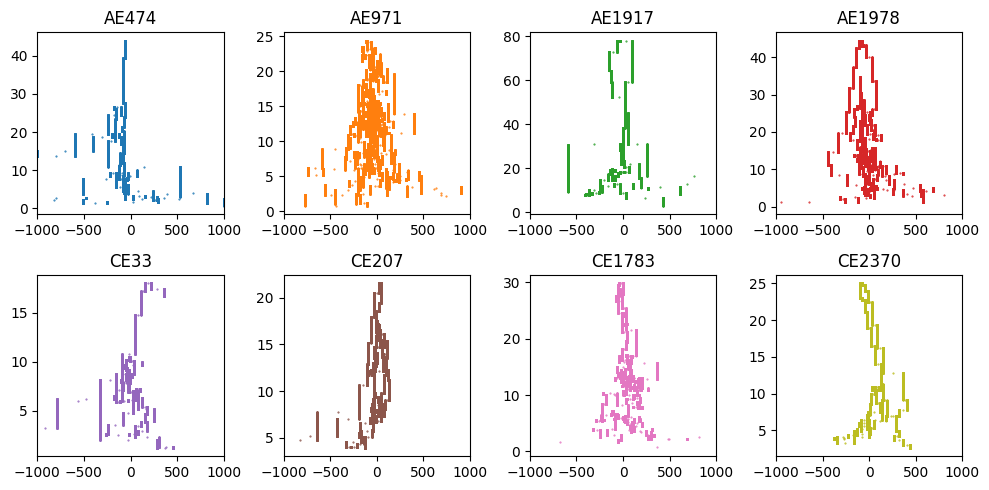

In [50]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = np.arange(len(df))
    th = df.TiltDir.to_numpy(dtype=float)
    mag = df.TiltDis.to_numpy(dtype=float)  # >= 0

    r_new = np.arange(r.min(), r.max(), 0.001)

    # --- angle (unwrap → interp → wrap) ---
    m_th = ~np.isnan(th)
    th_wrap = np.full_like(r_new, np.nan, dtype=float)
    if m_th.sum() > 1:
        th_unwrap = np.unwrap(np.deg2rad(th[m_th]), discont=np.deg2rad(180))
        thi = np.interp(r_new, r[m_th], th_unwrap, left=np.nan, right=np.nan)
        th_wrap = (np.rad2deg(thi)) % 360
    phi = np.deg2rad(th_wrap)

    # --- magnitude (linear interp, no extrapolation) ---
    m_mag = ~np.isnan(mag)
    mag_interp = np.full_like(r_new, np.nan, dtype=float)
    if m_mag.sum() > 1:
        mag_interp = np.interp(r_new, r[m_mag], mag[m_mag], left=np.nan, right=np.nan)
        mag_interp = np.maximum(mag_interp, 0)  # keep non-negative

    # plot only where both are finite
    ok = np.isfinite(phi) & np.isfinite(mag_interp)

    # phi[ok], r_new[ok], mag_interp[ok]

    dphi_dday = np.gradient(phi[ok], r_new[ok]) * 1000 # per day

    ax.scatter(dphi_dday, mag_interp[ok], marker='.', s=1, color=colors[e])
    ax.set_xlim(-1000, 1000)

    ax.set_title(f"{df.iloc[0].Cyc}{eddy}")

plt.tight_layout()
plt.show()


In [48]:
0.001*1000

1.0

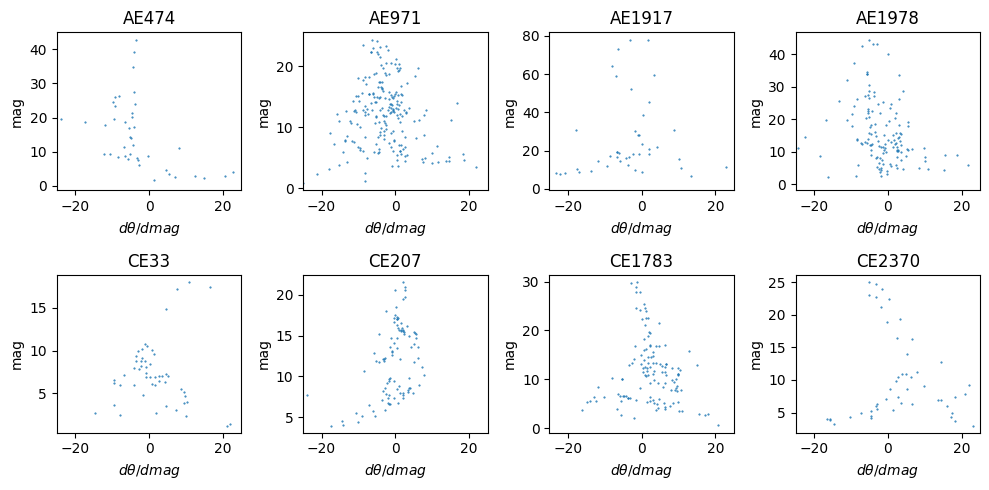

In [45]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = np.arange(len(df))
    th = df.TiltDir.to_numpy(dtype=float)
    mag = df.TiltDis.to_numpy(dtype=float)  # >= 0

    dth_dday = np.gradient(th, r)

    ax.scatter(dth_dday, mag, marker='.', s=1)
    ax.set_xlim(-25, 25)

    # ax.axvline(x=-20, color='k', lw=.5)
    # ax.axvline(x=20, color='k', lw=.5)

    ax.set_xlabel(r'$d\theta /dmag$')
    ax.set_ylabel('mag')

    ax.set_title(f"{df.iloc[0].Cyc}{eddy}")

plt.tight_layout()
plt.show()


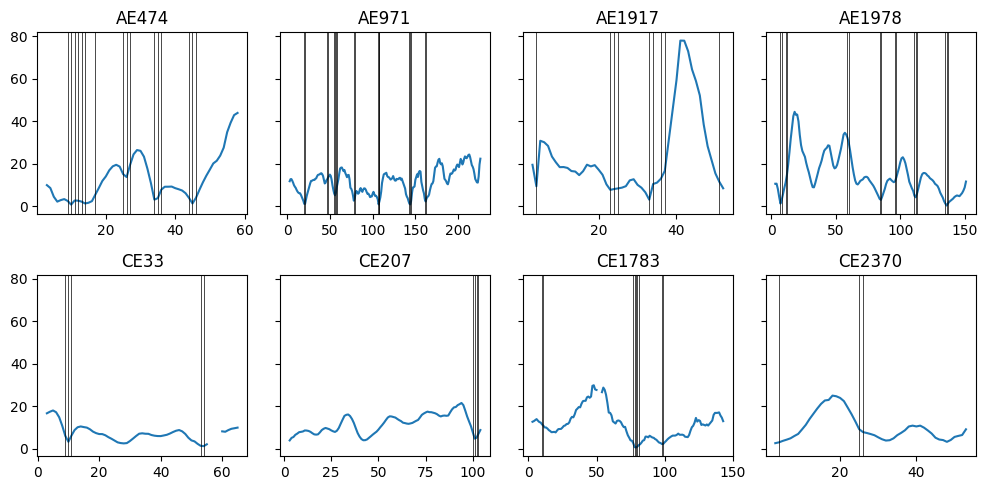

In [39]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = np.arange(len(df))
    th = df.TiltDir.to_numpy(dtype=float)
    mag = df.TiltDis.to_numpy(dtype=float)  # >= 0

    dth_dday = np.gradient(th, r)
    lrg_idx = np.where(np.abs(dth_dday) >= 20)[0]
    
    ax.plot(r, mag)

    for idx in lrg_idx:
        ax.axvline(x=r[idx], color='k', lw=.5)
    
    ax.set_title(f"{df.iloc[0].Cyc}{eddy}")

plt.tight_layout()
plt.show()


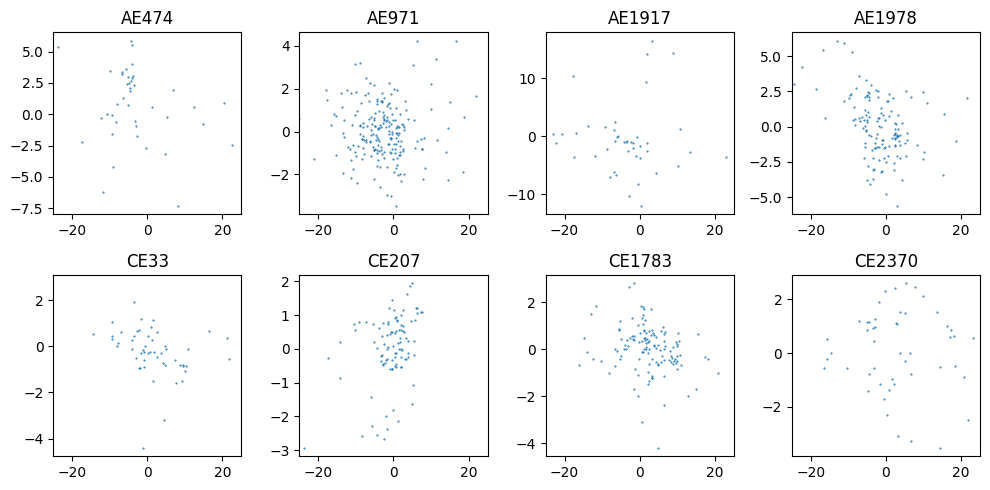

In [42]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = np.arange(len(df))
    th = df.TiltDir.to_numpy(dtype=float)
    mag = df.TiltDis.to_numpy(dtype=float)  # >= 0

    dphi_dday = np.gradient(th, r)
    dmag_dday = np.gradient(mag, r)

    ax.scatter(dphi_dday, dmag_dday, marker='.', s=1)
    ax.set_xlim(-25, 25)

    # ax.axvline(x=-20, color='k', lw=.5)
    # ax.axvline(x=20, color='k', lw=.5)

    ax.set_title(f"{df.iloc[0].Cyc}{eddy}")

plt.tight_layout()
plt.show()